In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.linear_model import LinearRegression
from collections import Counter
from scipy import stats
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import math
from matplotlib.pyplot import figure
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.metrics import log_loss  # To calculate cross-entropy
from sklearn.model_selection import train_test_split

## new

In [2]:
## optional
## delete celltypes with cell counts lower than certain amount
## specifing an lower bond is a must
def filter_low_counts(celltype_df, age_df, celltype_col, threshold):
    print("Checking low count cell types...")
    
    celltype_count = Counter(celltype_df[celltype_col])
    for key in celltype_count:
        if threshold == None:
            unique_ages = np.unique(age_df)
            num_groups = (len(unique_ages) + 1) * 100
            if celltype_count[key] < num_groups:
                print(key, " has too low counts")
                celltype_df = celltype_df[celltype_df[celltype_col] != key]
        else:
            if celltype_count[key] < threshold:
                print(key, " has too low counts")
                celltype_df = celltype_df[celltype_df[celltype_col] != key]
    return celltype_df

## old

In [3]:
def get_skewed_count_info(adata, class_col, age_col, age_threshold):
    print("Checking skewed count cell types...")
    
    # Compute the fraction of cells for each age group within each cell ontology class
    group_counts = adata.obs.groupby([class_col, age_col]).size()
    total_counts = adata.obs.groupby([class_col]).size()
    
    # Calculate the fraction of each age group within each class
    class_age_fraction = group_counts / total_counts
    
    # Find the cell classes to filter out based on age distribution
    classes_to_filter = class_age_fraction[class_age_fraction > age_threshold].index.get_level_values(0).unique()
    
    return classes_to_filter

In [4]:
## Read h5ad file 
## and do cell type filtering based on age distribution and cell count thresholds.
def read_and_filter_h5ad(filepath, class_col="celltype", age_col="age", age_threshold=0.8, count_threshold=None):
    """Parameters:
    adata: AnnData object
        The Scanpy AnnData object containing single-cell data.
    class_col: str, optional (default: 'celltype')
        The column name in adata.obs representing the cell ontology class.
    age_col: str, optional (default: 'age')
        The column name in adata.obs representing the age of the cells.
    age_threshold: float, optional (default: 0.8)
        The threshold fraction for filtering based on age distribution. If one age group has more than this
        fraction of cells in a class, the class will be filtered out.
    count_threshold: list, optional (default: [100])
        Threshold for filtering cell types based on count. If a single value is provided,
        it filters out cell types with counts lower than this value. If a range is provided,
        it filters out cell types outside this range.
    
    Returns:
    filtered_adata: AnnData object
        The filtered AnnData object with specified cell ontology classes removed based on both criteria."""
    try:
        adata = sc.read_h5ad(filepath)
        celltype_df = adata.obs[[class_col]].copy()
        age_df = adata.obs[[age_col]].copy()
        
        # Apply the cell count threshold filtering
        celltype_df = filter_low_counts(celltype_df, age_df, class_col, count_threshold)
    
        # Create a filtered AnnData object based on cell count filtering
        filtered_adata = adata[celltype_df.index].copy()
        
        # Identify the skewed classes to filter based on age distribution
        classes_to_filter = get_skewed_count_info(filtered_adata, class_col, age_col, age_threshold)
        
        if len(classes_to_filter):
            print(classes_to_filter[0], " has skewed cell counts")
        # Further filter the AnnData object based on age distribution
        final_filtered_adata = filtered_adata[~filtered_adata.obs[class_col].isin(classes_to_filter)].copy()
        
        return final_filtered_adata
    except Exception as e:
        raise(e)

In [6]:
## cell type annotation obtained from the original paper
adata = read_and_filter_h5ad("Liver_droplet.h5ad", "cell_ontology_class", "age", count_threshold=None)

C:\Users\Hang Yu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\anndata\compat\__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
C:\Users\Hang Yu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\anndata\compat\__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


Checking low count cell types...
endothelial cell of hepatic sinusoid  has too low counts
hepatic stellate cell  has too low counts
NK cell  has too low counts
plasmacytoid dendritic cell  has too low counts
B cell  has too low counts
myeloid leukocyte  has too low counts
Checking skewed count cell types...


In [32]:
# celltype_df = pd.DataFrame(adata.obs["cell_ontology_class"])
# celltype_df = celltype_df.rename(columns={"cell_ontology_class": "celltype"})
# age_df = pd.DataFrame(adata.obs["age"])
# age_df = age_df.rename(columns={"age": "age"})

In [33]:
sc.set_figure_params(scanpy=True, fontsize=16)

In [34]:
font_size_config = {
    'axes.titlesize': 16,  # Title font size
    'axes.labelsize': 14,  # Axes labels (x and y) font size
    'xtick.labelsize': 12,  # X-axis tick label font size
    'ytick.labelsize': 12,  # Y-axis tick label font size
}

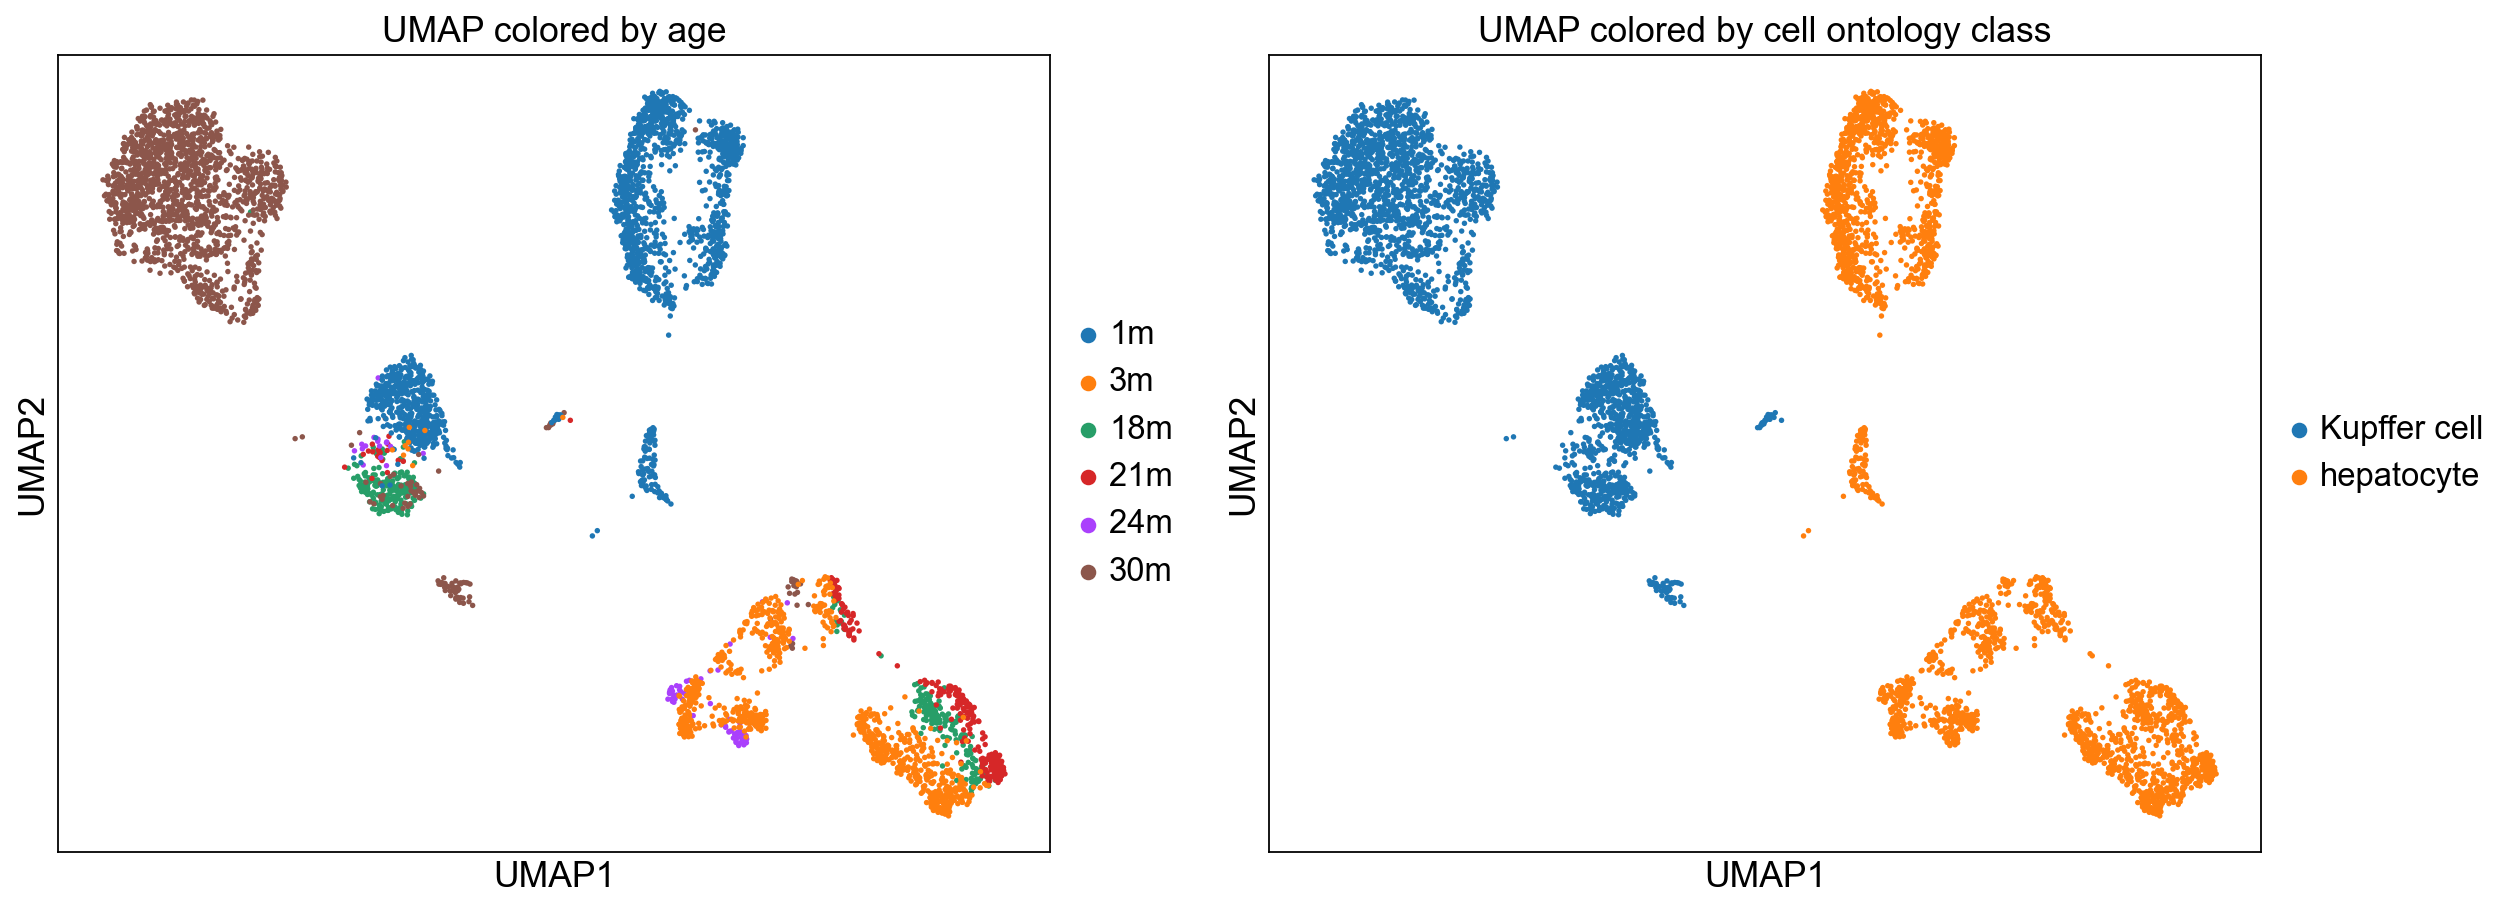

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

with plt.rc_context(font_size_config):
    sc.pl.umap(adata, color="age", ax=axs[0], show=False, title='UMAP colored by age')

    sc.pl.umap(adata, color="cell_ontology_class", ax=axs[1], show=False, title='UMAP colored by cell ontology class')

plt.tight_layout()
plt.show()

In [36]:
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.filter_cells(adata, min_genes=500)
adata

AnnData object with n_obs × n_vars = 4964 × 14595
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'louvain', 'cluster_names'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'louvain', 'neighbors', 'pca', 'rank_genes_groups', 'age_colors', 'cell_ontology_class_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [37]:
adata.obs['n_counts'] = np.sum(adata.X, axis=1).A1
adata

AnnData object with n_obs × n_vars = 4964 × 14595
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'louvain', 'cluster_names'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'louvain', 'neighbors', 'pca', 'rank_genes_groups', 'age_colors', 'cell_ontology_class_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [38]:
adata = adata[adata.obs['n_counts']>=3000]
adata

View of AnnData object with n_obs × n_vars = 4963 × 14595
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'louvain', 'cluster_names'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'louvain', 'neighbors', 'pca', 'rank_genes_groups', 'age_colors', 'cell_ontology_class_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [39]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4) #simple lib size normalization?
adata.raw = adata

/home/hang/.local/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:580: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [40]:
adata = sc.pp.filter_genes_dispersion(adata, subset = False, min_disp=.5, max_disp=None, 
                              min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None, 
                              log=True, copy=True)
adata

AnnData object with n_obs × n_vars = 4963 × 14595
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'louvain', 'cluster_names'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'louvain', 'neighbors', 'pca', 'rank_genes_groups', 'age_colors', 'cell_ontology_class_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [41]:
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10, zero_center=False)
sc.tl.pca(adata,use_highly_variable=True)

/home/hang/.local/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


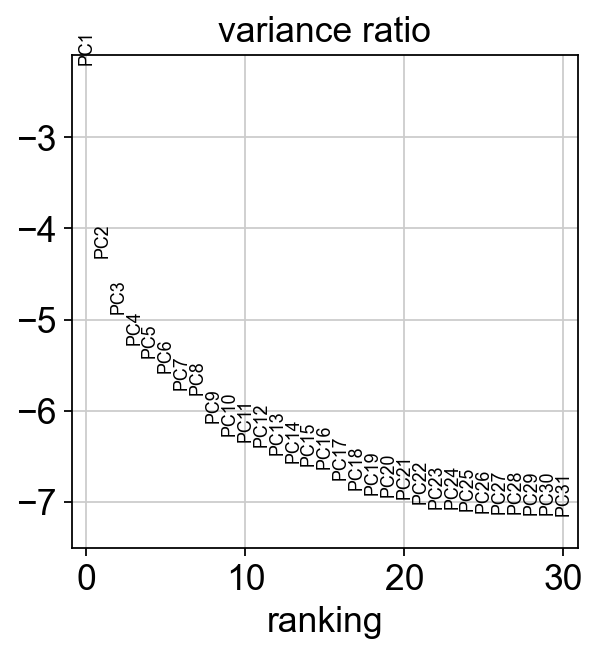

In [42]:
sc.pl.pca_variance_ratio(adata, log=True)

/home/hang/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8942 (\N{VERTICAL ELLIPSIS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


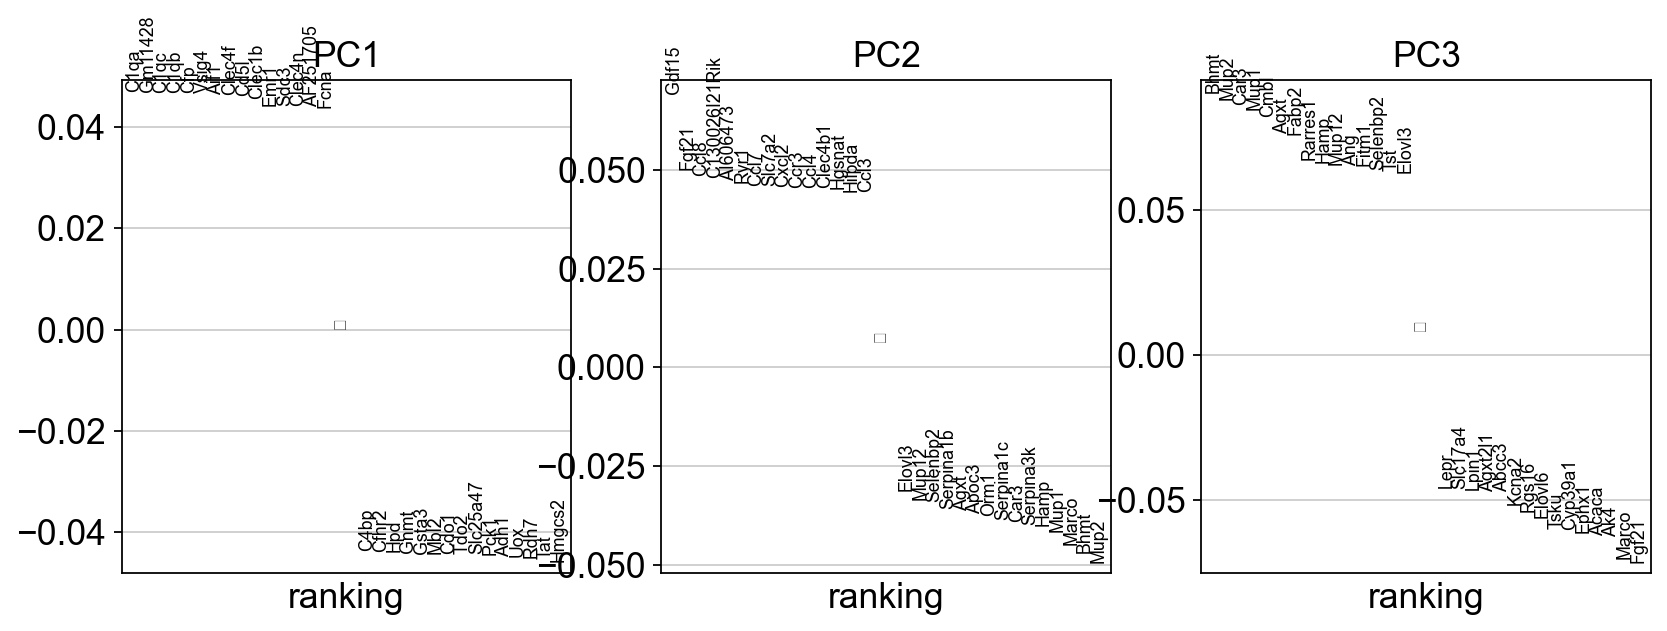

In [43]:
sc.pl.pca_loadings(adata)

In [44]:
sc.pp.neighbors(adata, n_neighbors=16)
sc.tl.louvain(adata, resolution = 1)

In [45]:
sc.tl.umap(adata)

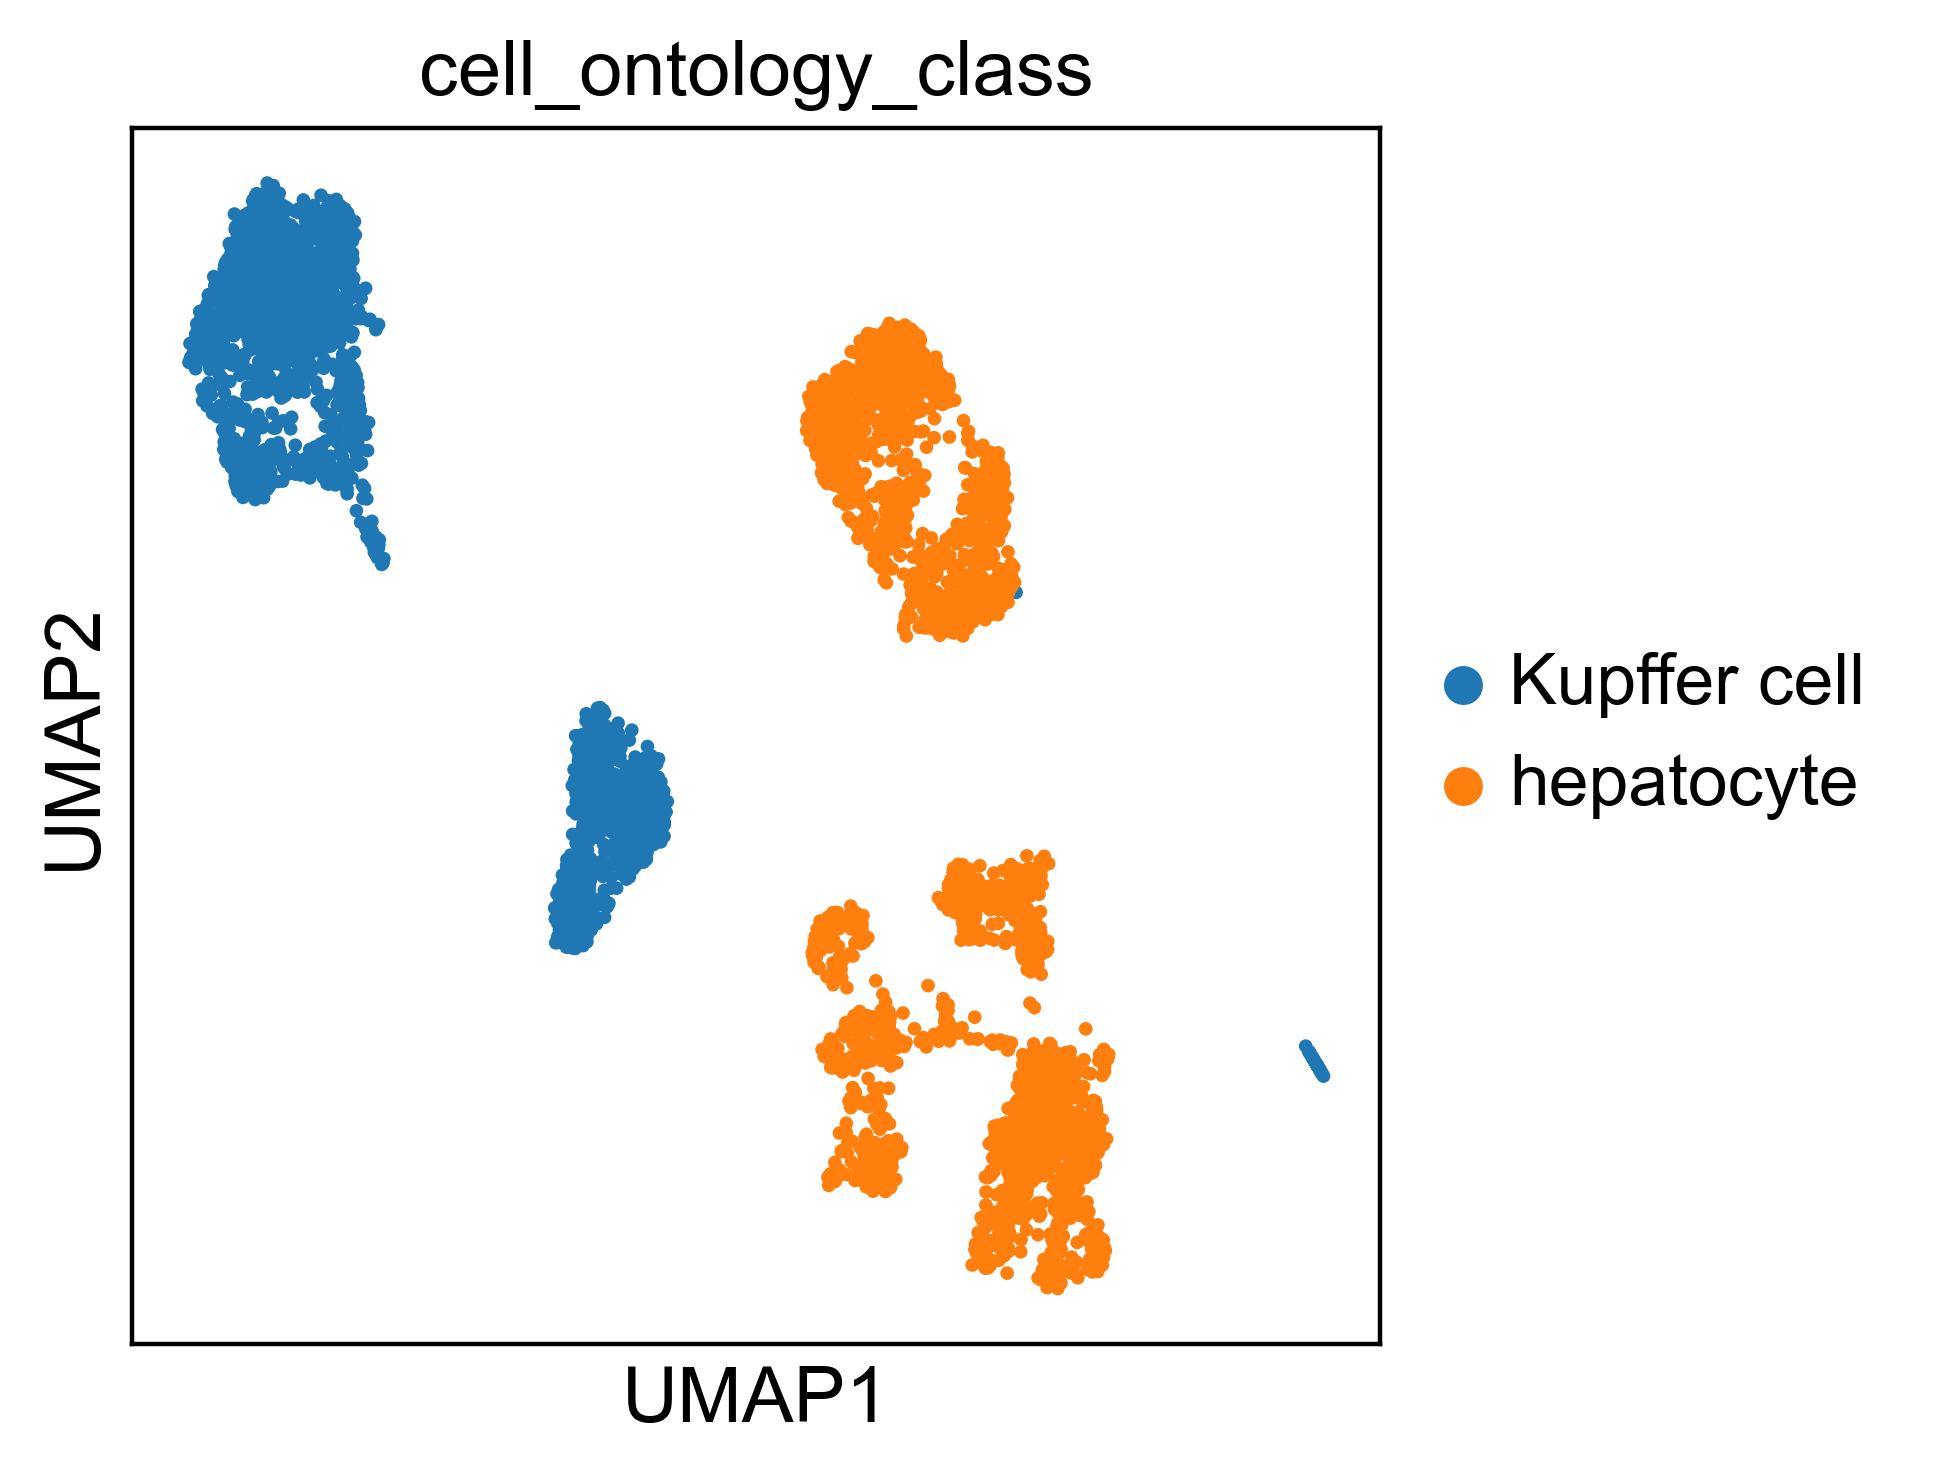

In [46]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color=['cell_ontology_class'])

In [47]:
# np.random.seed(42) ## old
np.random.seed(20)

# Group cells by their cluster assignment from 'cell_ontology_class'
clusters = adata.obs['cell_ontology_class'].unique()
age_groups = adata.obs['age'].unique()

# Create a list to store the indices of the randomly selected cells
random_indices = defaultdict(dict)

default_num_neighbors = 100

# Loop through each cluster and select random cells
for cluster in clusters:
    for age in age_groups:
        cluster_indices = adata.obs.index[(adata.obs['cell_ontology_class'] == cluster) & (adata.obs["age"] == age)]
        n_cells = len(cluster_indices)
        print(f"celltype {cluster} at age {age} has {n_cells} number of cells")
        if n_cells < default_num_neighbors * 2 and n_cells != 0:
            n_random_cells_per_cluster = math.floor(n_cells / 10)
            print(f"selected {n_random_cells_per_cluster} for this {cluster} celltype at age {age}")
            selected_indices = np.random.choice(cluster_indices, size=n_random_cells_per_cluster, replace=False)
            random_indices[cluster][age] = selected_indices
        elif n_cells == 0:
            continue
        else:
            n_random_cells_per_cluster = math.floor(n_cells / default_num_neighbors)
            print(f"selected {n_random_cells_per_cluster} for this {cluster} celltype at age {age}")
            selected_indices = np.random.choice(cluster_indices, size=n_random_cells_per_cluster, replace=False)
            random_indices[cluster][age] = selected_indices

celltype hepatocyte at age 18m has 194 number of cells
selected 19 for this hepatocyte celltype at age 18m
celltype hepatocyte at age 21m has 229 number of cells
selected 2 for this hepatocyte celltype at age 21m
celltype hepatocyte at age 24m has 63 number of cells
selected 6 for this hepatocyte celltype at age 24m
celltype hepatocyte at age 30m has 23 number of cells
selected 2 for this hepatocyte celltype at age 30m
celltype hepatocyte at age 1m has 1239 number of cells
selected 12 for this hepatocyte celltype at age 1m
celltype hepatocyte at age 3m has 828 number of cells
selected 8 for this hepatocyte celltype at age 3m
celltype Kupffer cell at age 18m has 195 number of cells
selected 19 for this Kupffer cell celltype at age 18m
celltype Kupffer cell at age 21m has 21 number of cells
selected 2 for this Kupffer cell celltype at age 21m
celltype Kupffer cell at age 24m has 18 number of cells
selected 1 for this Kupffer cell celltype at age 24m
celltype Kupffer cell at age 30m has 1

In [48]:
if 'X_umap' not in adata.obsm.keys():
    sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_pca')
    sc.tl.umap(adata)

In [49]:
adata

AnnData object with n_obs × n_vars = 4963 × 14595
    obs: 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'n_counts', 'louvain', 'cluster_names'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'mean', 'std'
    uns: 'louvain', 'neighbors', 'pca', 'rank_genes_groups', 'age_colors', 'cell_ontology_class_colors', 'log1p', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [50]:
random_indices

defaultdict(dict,
            {'hepatocyte': {'18m': array(['ACTGTCCCAAGTTCTG-1-9-0-0', 'CGGCTAGCAATGTTGC-1-10-0-0',
                     'CATCAAGAGGCCGAAT-1-9-0-0', 'ACCTTTAAGTTATCGC-1-9-0-0',
                     'CACAGTACATATGGTC-1-9-0-0', 'GTATCTTTCCTGCTTG-1-9-0-0',
                     'ACGAGGAGTACCTACA-1-10-0-0', 'GGTGAAGCACGAGGTA-1-9-0-0',
                     'GCAAACTAGAGTGACC-1-9-0-0', 'GGGCATCAGATTACCC-1-9-0-0',
                     'CTCGGAGAGCGATAGC-1-10-0-0', 'GTATTCTCATGGATGG-1-9-0-0',
                     'GCACATAAGAGAGCTC-1-9-0-0', 'GTAGGCCGTCCAGTTA-1-9-0-0',
                     'AGCTCCTCACATTAGC-1-9-0-0', 'GATGCTAAGCTACCGC-1-9-0-0',
                     'GTACTCCGTTCCGTCT-1-10-0-0', 'GATCGCGTCTACCTGC-1-9-0-0',
                     'CTTACCGAGGGTGTTG-1-9-0-0'], dtype=object),
              '21m': array(['CACCACTCAGTTTACG-1-49-0-0', 'GACTAACTCTTGCAAG-1-49-0-0'],
                    dtype=object),
              '24m': array(['GCTGCGAGTCTAGTCA-1-76-0-0', 'GTAACGTAGGACATTA-1-

In [51]:
from scipy.spatial import distance_matrix
# Extract the UMAP coordinates
umap_coords = adata.obsm['X_umap']
umap_df = pd.DataFrame(adata.obsm['X_umap'], columns=['UMAP_1', 'UMAP_2'])
umap_df.index = adata.obs.index

# distance_df = pd.DataFrame(adata.obsp["distances"].toarray())
# distance_df.index = adata.obs.index
# distance_df.columns = adata.obs.index

meta_cells_per_celltype = {}
meta_cells_mapping_ages = defaultdict(list)
substring = "m"
gene_names = adata.var_names

neighbors = defaultdict(dict)

for cluster in random_indices:
    print(f"Working on cluster {cluster}...")
    curr_dataframe = pd.DataFrame(columns = gene_names)
    cell_num = 0
    for age in random_indices[cluster]:
        print(f"{age} group")
        cluster_indices = adata.obs.index[(adata.obs['cell_ontology_class'] == cluster) & (adata.obs["age"] == age)]
        curr_cluster = random_indices[cluster][age]
        selected_coords = umap_df.loc[cluster_indices, :]
        print(f"number of cells {selected_coords.shape}")
        # default Number of nearest neighbors to find
        default_num_neighbors = 100
        age_info = int(age.strip(substring))
        curr_neighbors = {}
        for i, cell in enumerate(curr_cluster):
            print(f"Cell {i} {cell} of {cluster}")
            neighbor_coords = selected_coords.drop(cell).to_numpy()
            if len(neighbor_coords) < default_num_neighbors * 2:
                n_neighbors = math.floor(len(neighbor_coords) / 10)
                cell_distances = distance_matrix(neighbor_coords, selected_coords.loc[[cell], :]).flatten()
                nearest_indices = np.argsort(cell_distances)[:n_neighbors]
                nearest_real_indices = np.array(cluster_indices)[nearest_indices]
                raw_counts_neighbors = adata[nearest_real_indices, :].X
                
                curr_neighbors[cell] = (adata[nearest_real_indices, :].obs.index)
                
                total_counts = pd.DataFrame(raw_counts_neighbors.sum(axis=0), index = [f"cell {cell_num}"], columns=gene_names)
                curr_dataframe = pd.concat([curr_dataframe, total_counts], axis=0)
                meta_cells_mapping_ages[cluster].append(age_info)
                cell_num += 1
            else:
                cell_distances = distance_matrix(neighbor_coords, selected_coords.loc[[cell], :]).flatten()
                nearest_indices = np.argsort(cell_distances)[:default_num_neighbors]
                nearest_real_indices = np.array(cluster_indices)[nearest_indices]
                raw_counts_neighbors = adata[nearest_real_indices, :].X
                
                curr_neighbors[cell] = (adata[nearest_real_indices, :].obs.index)
                
                total_counts = pd.DataFrame(raw_counts_neighbors.sum(axis=0), index = [f"cell {cell_num}"], columns=gene_names)
                curr_dataframe = pd.concat([curr_dataframe, total_counts], axis=0)
                meta_cells_mapping_ages[cluster].append(age_info)
                cell_num += 1
    #         print(total_counts.shape)
        neighbors[cluster][age] = curr_neighbors
    meta_cells_per_celltype[cluster] = curr_dataframe

Working on cluster hepatocyte...
18m group
number of cells (194, 2)
Cell 0 ACTGTCCCAAGTTCTG-1-9-0-0 of hepatocyte
Cell 1 CGGCTAGCAATGTTGC-1-10-0-0 of hepatocyte
Cell 2 CATCAAGAGGCCGAAT-1-9-0-0 of hepatocyte
Cell 3 ACCTTTAAGTTATCGC-1-9-0-0 of hepatocyte
Cell 4 CACAGTACATATGGTC-1-9-0-0 of hepatocyte
Cell 5 GTATCTTTCCTGCTTG-1-9-0-0 of hepatocyte
Cell 6 ACGAGGAGTACCTACA-1-10-0-0 of hepatocyte
Cell 7 GGTGAAGCACGAGGTA-1-9-0-0 of hepatocyte
Cell 8 GCAAACTAGAGTGACC-1-9-0-0 of hepatocyte
Cell 9 GGGCATCAGATTACCC-1-9-0-0 of hepatocyte
Cell 10 CTCGGAGAGCGATAGC-1-10-0-0 of hepatocyte
Cell 11 GTATTCTCATGGATGG-1-9-0-0 of hepatocyte
Cell 12 GCACATAAGAGAGCTC-1-9-0-0 of hepatocyte
Cell 13 GTAGGCCGTCCAGTTA-1-9-0-0 of hepatocyte
Cell 14 AGCTCCTCACATTAGC-1-9-0-0 of hepatocyte
Cell 15 GATGCTAAGCTACCGC-1-9-0-0 of hepatocyte
Cell 16 GTACTCCGTTCCGTCT-1-10-0-0 of hepatocyte
Cell 17 GATCGCGTCTACCTGC-1-9-0-0 of hepatocyte
Cell 18 CTTACCGAGGGTGTTG-1-9-0-0 of hepatocyte
21m group
number of cells (229, 2)
Cell 0 CAC

/tmp/ipykernel_8421/3219694693.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  curr_dataframe = pd.concat([curr_dataframe, total_counts], axis=0)


Cell 1 GCTTCCATCATGTCTT-1-28-1-0 of hepatocyte
1m group
number of cells (1239, 2)
Cell 0 TAAGCGTCACACCGCA-1-44-1-0 of hepatocyte
Cell 1 GTCACAACATTGAGCT-1-44-1-0 of hepatocyte
Cell 2 GGCTCGACATAACCTG-1-43-1-0 of hepatocyte
Cell 3 CGTGAGCTCAGAGACG-1-43-1-0 of hepatocyte
Cell 4 GCTGCAGTCACGCGGT-1-44-1-0 of hepatocyte
Cell 5 GAAGCAGCAATGACCT-1-44-1-0 of hepatocyte
Cell 6 ATCCGAAAGAAGATTC-1-44-1-0 of hepatocyte
Cell 7 GGGCACTGTCTCCATC-1-44-1-0 of hepatocyte
Cell 8 CCTACACAGCTATGCT-1-43-1-0 of hepatocyte
Cell 9 TGGCGCAAGTTGAGAT-1-50-1-0 of hepatocyte
Cell 10 GCGCAACTCTCAAGTG-1-44-1-0 of hepatocyte
Cell 11 AACTTTCCACCAGCAC-1-44-1-0 of hepatocyte
3m group
number of cells (828, 2)
Cell 0 10X_P7_1_GGCGTGTCATGCCTTC-1 of hepatocyte
Cell 1 10X_P7_0_CCTAGCTAGTTCGATC-1 of hepatocyte
Cell 2 10X_P4_2_ATCTACTAGTCGTTTG-1 of hepatocyte
Cell 3 10X_P7_1_TGCGCAGTCTACGAGT-1 of hepatocyte
Cell 4 10X_P7_0_ACCTTTAGTCGCTTCT-1 of hepatocyte
Cell 5 10X_P7_0_CATGCCTGTAGCGCTC-1 of hepatocyte
Cell 6 10X_P4_2_GGTGTTAC

/tmp/ipykernel_8421/3219694693.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  curr_dataframe = pd.concat([curr_dataframe, total_counts], axis=0)


Cell 7 CGGCTAGCAACGATCT-1-16-1-0 of Kupffer cell
Cell 8 ACACCAAGTCACCCAG-1-16-1-0 of Kupffer cell
Cell 9 CGATTGAGTACTTGAC-1-16-1-0 of Kupffer cell
Cell 10 CTCACACCATAGGATA-1-16-1-0 of Kupffer cell
Cell 11 GTTCATTTCAACCAAC-1-16-1-0 of Kupffer cell
Cell 12 TGAGAGGCAATCACAC-1-16-1-0 of Kupffer cell
Cell 13 CGCTATCTCGAGGTAG-1-16-1-0 of Kupffer cell
Cell 14 ATCTGCCGTTCGTTGA-1-16-1-0 of Kupffer cell
Cell 15 AGAGTGGCATCCGTGG-1-16-1-0 of Kupffer cell
1m group
number of cells (494, 2)
Cell 0 GATGCTAAGACAAGCC-1-50-1-0 of Kupffer cell
Cell 1 TAGACCAGTCCAACTA-1-50-1-0 of Kupffer cell
Cell 2 CTCTAATAGAGTCTGG-1-50-1-0 of Kupffer cell
Cell 3 GGACAGAAGAAGGCCT-1-50-1-0 of Kupffer cell
3m group
number of cells (9, 2)


## Start working on the gene correlation

In [52]:
celltype_df = pd.DataFrame(adata.obs["cell_ontology_class"])
celltype_df = celltype_df.rename(columns={"cell_ontology_class": "celltype"})
age_df = pd.DataFrame(adata.obs["age"])
age_df = age_df.rename(columns={"age": "age"})

In [53]:
def clean_age(age_df, substring):
    values = []
    for x in age_df["age"]:
        try:
            # Attempt to strip the substring and convert to integer
            value = int(x.strip(substring))
            values.append(value)
        except ValueError:
            # Handle the case where conversion fails
            warnings.warn(f"Warning: '{x}' could not be converted to an integer.")
            break
    age_df["age"] = values
    return age_df

In [54]:
cleaned_age_df = clean_age(age_df, "m")

In [55]:
cleaned_age_df

age
index                           
AAAGCAATCGGAAATA-1-9-0-0      18
AAAGTAGAGGCCCTTG-1-9-0-0      18
AACCGCGAGAAACCGC-1-9-0-0      18
AACTCCCAGTTGTCGT-1-9-0-0      18
AACTCCCGTAACGTTC-1-9-0-0      18
...                          ...
10X_P7_1_TTGACTTTCCGCGGTA-1    3
10X_P7_1_TTGCCGTCAGCCAATT-1    3
10X_P7_1_TTGGAACTCTGACCTC-1    3
10X_P7_1_TTTACTGCATTACGAC-1    3
10X_P7_1_TTTGCGCGTAAGGATT-1    3

[4963 rows x 1 columns]

## Get raw counts

In [56]:
def get_raw_counts(adata, celltype_df):
    raw_count = pd.DataFrame.sparse.from_spmatrix(adata.X.T, 
                                               index = adata.var_names, 
                                               columns = adata.obs_names).astype(int)
    ## clear out low count celltype if there is any
    raw_count = raw_count[list(celltype_df.index)]
    return raw_count

In [57]:
raw_count = get_raw_counts(adata, celltype_df)

In [58]:
### testing
raw_count.shape[1] == celltype_df.shape[0]

True

In [59]:
gene_names = np.array(raw_count.index)
celltype_dict = {}
for celltype in Counter(celltype_df["celltype"]):
    celltype_dict[celltype] = list(adata.obs[adata.obs["cell_ontology_class"] == celltype].index)
age_groups = np.unique(cleaned_age_df["age"])

In [60]:
from Helper.Load_matrix import get_normalized_matrix
threshold = 0.50
selected_gene_by_frac = dict()
for celltype in tqdm(celltype_df["celltype"].unique()):
    current_cells = raw_count[celltype_dict[celltype]] 
    norm_curr_cells = get_normalized_matrix(current_cells)
    
    mean_percent = norm_curr_cells.mean(axis=0)
    argsort_index = np.argsort(mean_percent).values
    counts_top_genes = norm_curr_cells.iloc[:, argsort_index]
    
    # Adjust selection to get top-expressing genes
    top_genes = list(counts_top_genes.columns)[-int(counts_top_genes.shape[1] * threshold):]
    selected_gene_by_frac[celltype] = top_genes

  0%|          | 0/2 [00:00<?, ?it/s]/home/hang/.local/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
 50%|█████     | 1/2 [00:00<00:00,  2.12it/s]/home/hang/.local/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
100%|██████████| 2/2 [00:00<00:00,  2.62it/s]


In [61]:
import os
cor_info_path = "HiExpr_correlation_info_matrix/Tabula_Muris_Liver"

In [62]:
if not os.path.exists(cor_info_path):
    os.makedirs(cor_info_path)
    print("Correlation output directory created successfully.")
else:
    print("Correlation output directory already exists.")

Correlation output directory created successfully.


In [63]:
correlated_genes = {}
correlations = {}
if not os.path.exists(cor_info_path):
    os.makedirs(cor_info_path)

for celltype in meta_cells_per_celltype:
    print(f"Processing cell type {celltype}...")
    curr_cells = meta_cells_per_celltype[celltype]  # Access the metacell dataframe for each cell type
    curr_genes = selected_gene_by_frac[celltype]  # Get the selected gene list for the current cell type
    curr_ages = meta_cells_mapping_ages[celltype]
    

    curr_corrs = []
    abs_curr_corrs = []

    for gene in curr_genes:
        gene_exprs = curr_cells[gene].values  # Get gene expression for the selected gene from the metacell dataframe
#         print(gene_exprs)
#         print(curr_ages)
#         print(len(gene_expr), len(curr_ages))
#         if len(curr_ages) > 1:  # Ensure we have more than one data point to calculate correlation
#             try:
        r, p_value = stats.pearsonr(gene_exprs, curr_ages)
        curr_corrs.append(r)
        abs_curr_corrs.append(abs(r))
#             except Exception as e:
#                 print(f"Error processing {celltype}, {gene}: {e}")
               
    # sort the correlations
    curr_corrs = np.nan_to_num(curr_corrs)
    
    abs_curr_corrs = np.nan_to_num(abs_curr_corrs)
    order = np.argsort(abs_curr_corrs)
    sorted_corrs = abs_curr_corrs[order][::-1]
    sorted_genes = np.array(curr_genes)[order][::-1]

    # store values 
    correlations[celltype] = sorted_corrs
    correlated_genes[celltype] = list(sorted_genes)

    # Save to CSV
    file = pd.DataFrame(curr_corrs, index=np.array(curr_genes), columns=["Pearson Correlation"])
    file_path = os.path.join(cor_info_path, f"no_absolute_{celltype}_subtype_correlations.csv")
#     file.to_csv(file_path)

/tmp/ipykernel_8421/3035901221.py:23: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p_value = stats.pearsonr(gene_exprs, curr_ages)


Processing cell type hepatocyte...
Processing cell type Kupffer cell...


/tmp/ipykernel_8421/3035901221.py:23: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p_value = stats.pearsonr(gene_exprs, curr_ages)


In [64]:
train_age_groups = {}
### pred_freqs are the fitted frequencies from linearRegression
pred_freq_matrices = {}
freq_matrices = {}
for celltype in meta_cells_per_celltype:
    df = pd.DataFrame(meta_cells_per_celltype[celltype])[correlated_genes[celltype]]
    df.index = meta_cells_mapping_ages[celltype]
    frequency_matrix = df.div(np.sum(df, axis = 1), axis = 0)
    frequency_matrix = frequency_matrix.fillna(0)
    freq_matrices[celltype] = frequency_matrix.T
    
    pred_freqs = np.zeros((frequency_matrix.shape))
    pred_freqs = pd.DataFrame(pred_freqs, columns=frequency_matrix.columns)
    train_age = np.array(meta_cells_mapping_ages[celltype]).reshape(-1,1)
    train_age_groups[celltype] = train_age
    for gene in frequency_matrix:
        reg = LinearRegression(n_jobs=1).fit(train_age, np.array(frequency_matrix[gene]))
        predictions = reg.predict(train_age)
        pred_freqs[gene] = predictions
    pred_freqs[pred_freqs < 0] = 1e-6
    pred_freqs.index = frequency_matrix.index
    pred_freqs = pred_freqs.groupby(pred_freqs.index).mean()
    pred_freqs = pred_freqs.T
    pred_freq_matrices[celltype] = pred_freqs

In [65]:
pred_freq_matrices["hepatocyte"]

1         3         18        21        24        30
index                                                                    
Cyp3a11        0.000662  0.000653  0.000591  0.000578  0.000566  0.000541
Cyp2c50        0.000549  0.000555  0.000602  0.000612  0.000621  0.000640
1810006K21Rik  0.000386  0.000388  0.000404  0.000407  0.000410  0.000417
Rpl22l1        0.000572  0.000559  0.000461  0.000441  0.000421  0.000382
Gnb2l1         0.001066  0.001054  0.000965  0.000947  0.000929  0.000893
...                 ...       ...       ...       ...       ...       ...
Sgpp2          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
Fkbp10         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
Def6           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
Gm11747        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
Dscc1          0.000000  0.000000  0.000000  0.000000  0.000000  0.000000

[6828 rows x 6 columns]

## test

num of meta cells: 49


100%|██████████| 9/9 [00:00<00:00, 327.07it/s]


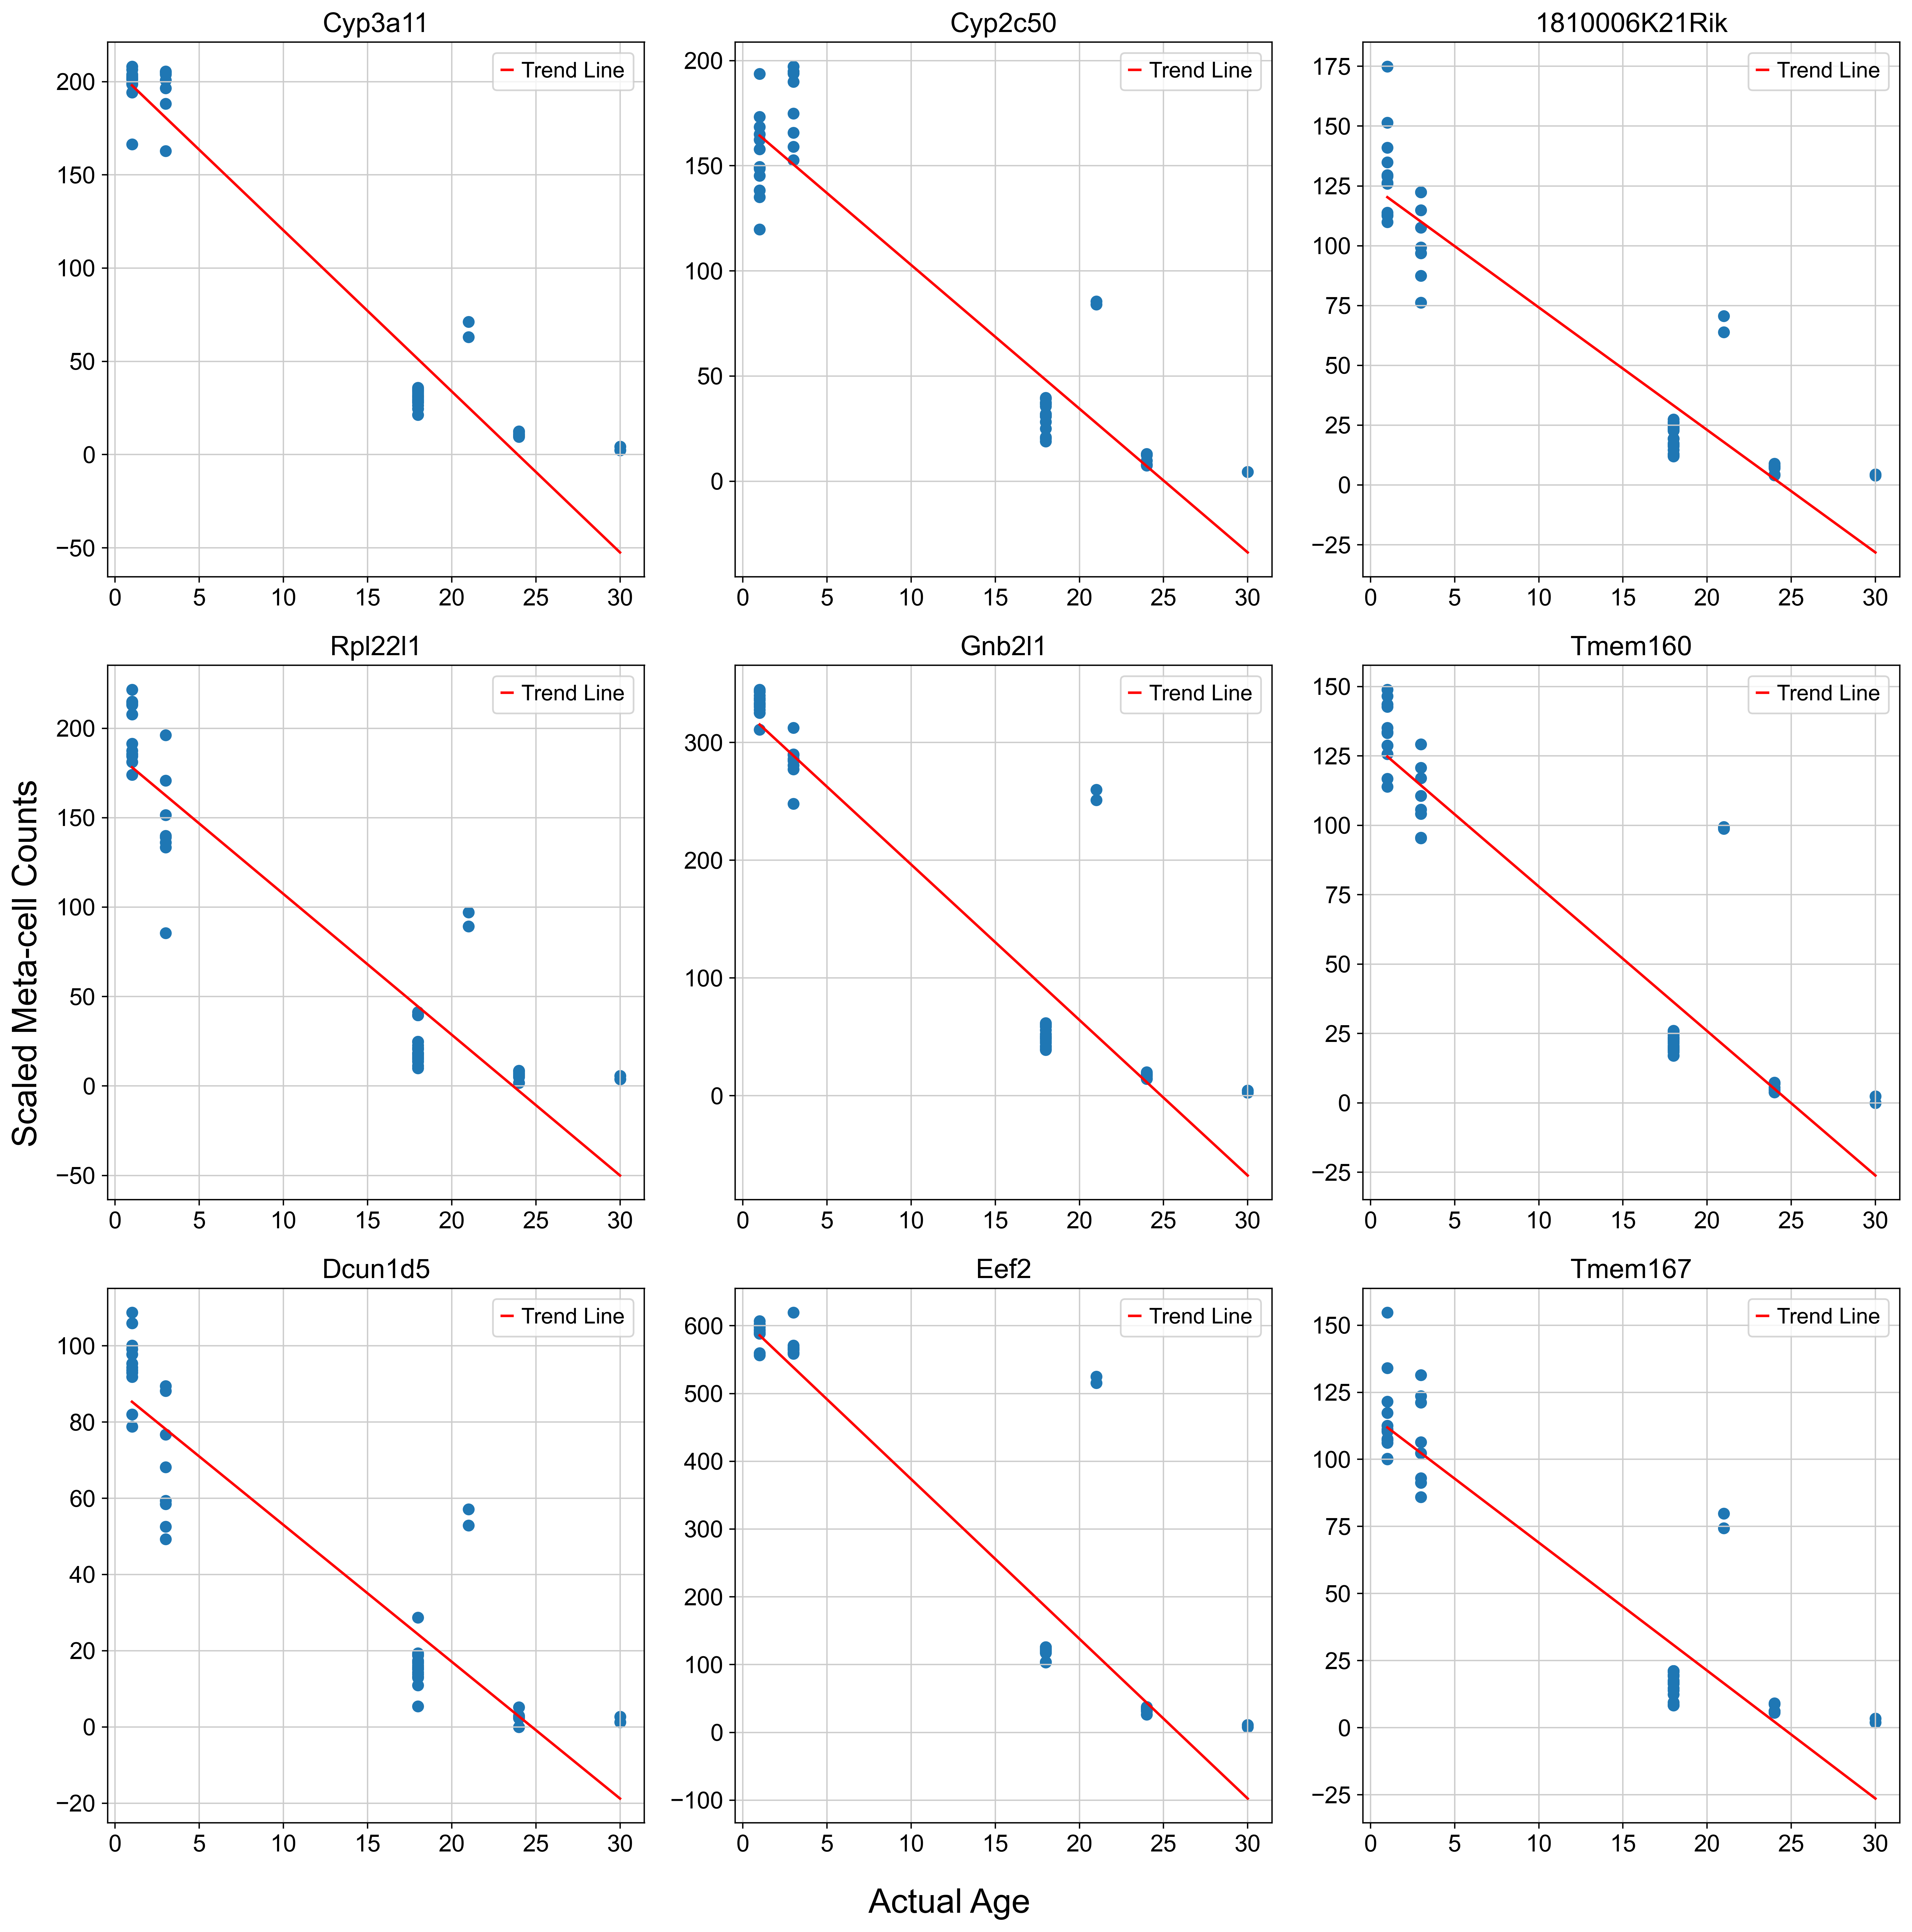

In [66]:
import seaborn as sns
figure, axes = plt.subplots(3, 3, figsize = (16,16))
axes = axes.ravel()
genes = correlated_genes["hepatocyte"][:9]
test_exprs = []
test_ages = meta_cells_mapping_ages["hepatocyte"]
print(f"num of meta cells: {len(test_ages)}")
test_cells = meta_cells_per_celltype["hepatocyte"]
for i in tqdm(range(len(genes))):
    gene_exprs = test_cells[genes[i]]  # Get gene expression for the selected gene
    axes[i].scatter(test_ages, gene_exprs)
    z = np.polyfit(test_ages, gene_exprs, 1)  # Fit line
    p = np.poly1d(z)  # Create line equation
    axes[i].plot(sorted(test_ages), p(sorted(test_ages)), label="Trend Line", color='r')  # Sort ages for a smooth line
    axes[i].set_title(genes[i], fontsize=16)
    axes[i].legend()

figure.supylabel("Scaled Meta-cell Counts", fontsize=20)
figure.supxlabel("Actual Age", fontsize=20)
figure.tight_layout()
plt.show()

100%|██████████| 9/9 [00:00<00:00, 578.25it/s]


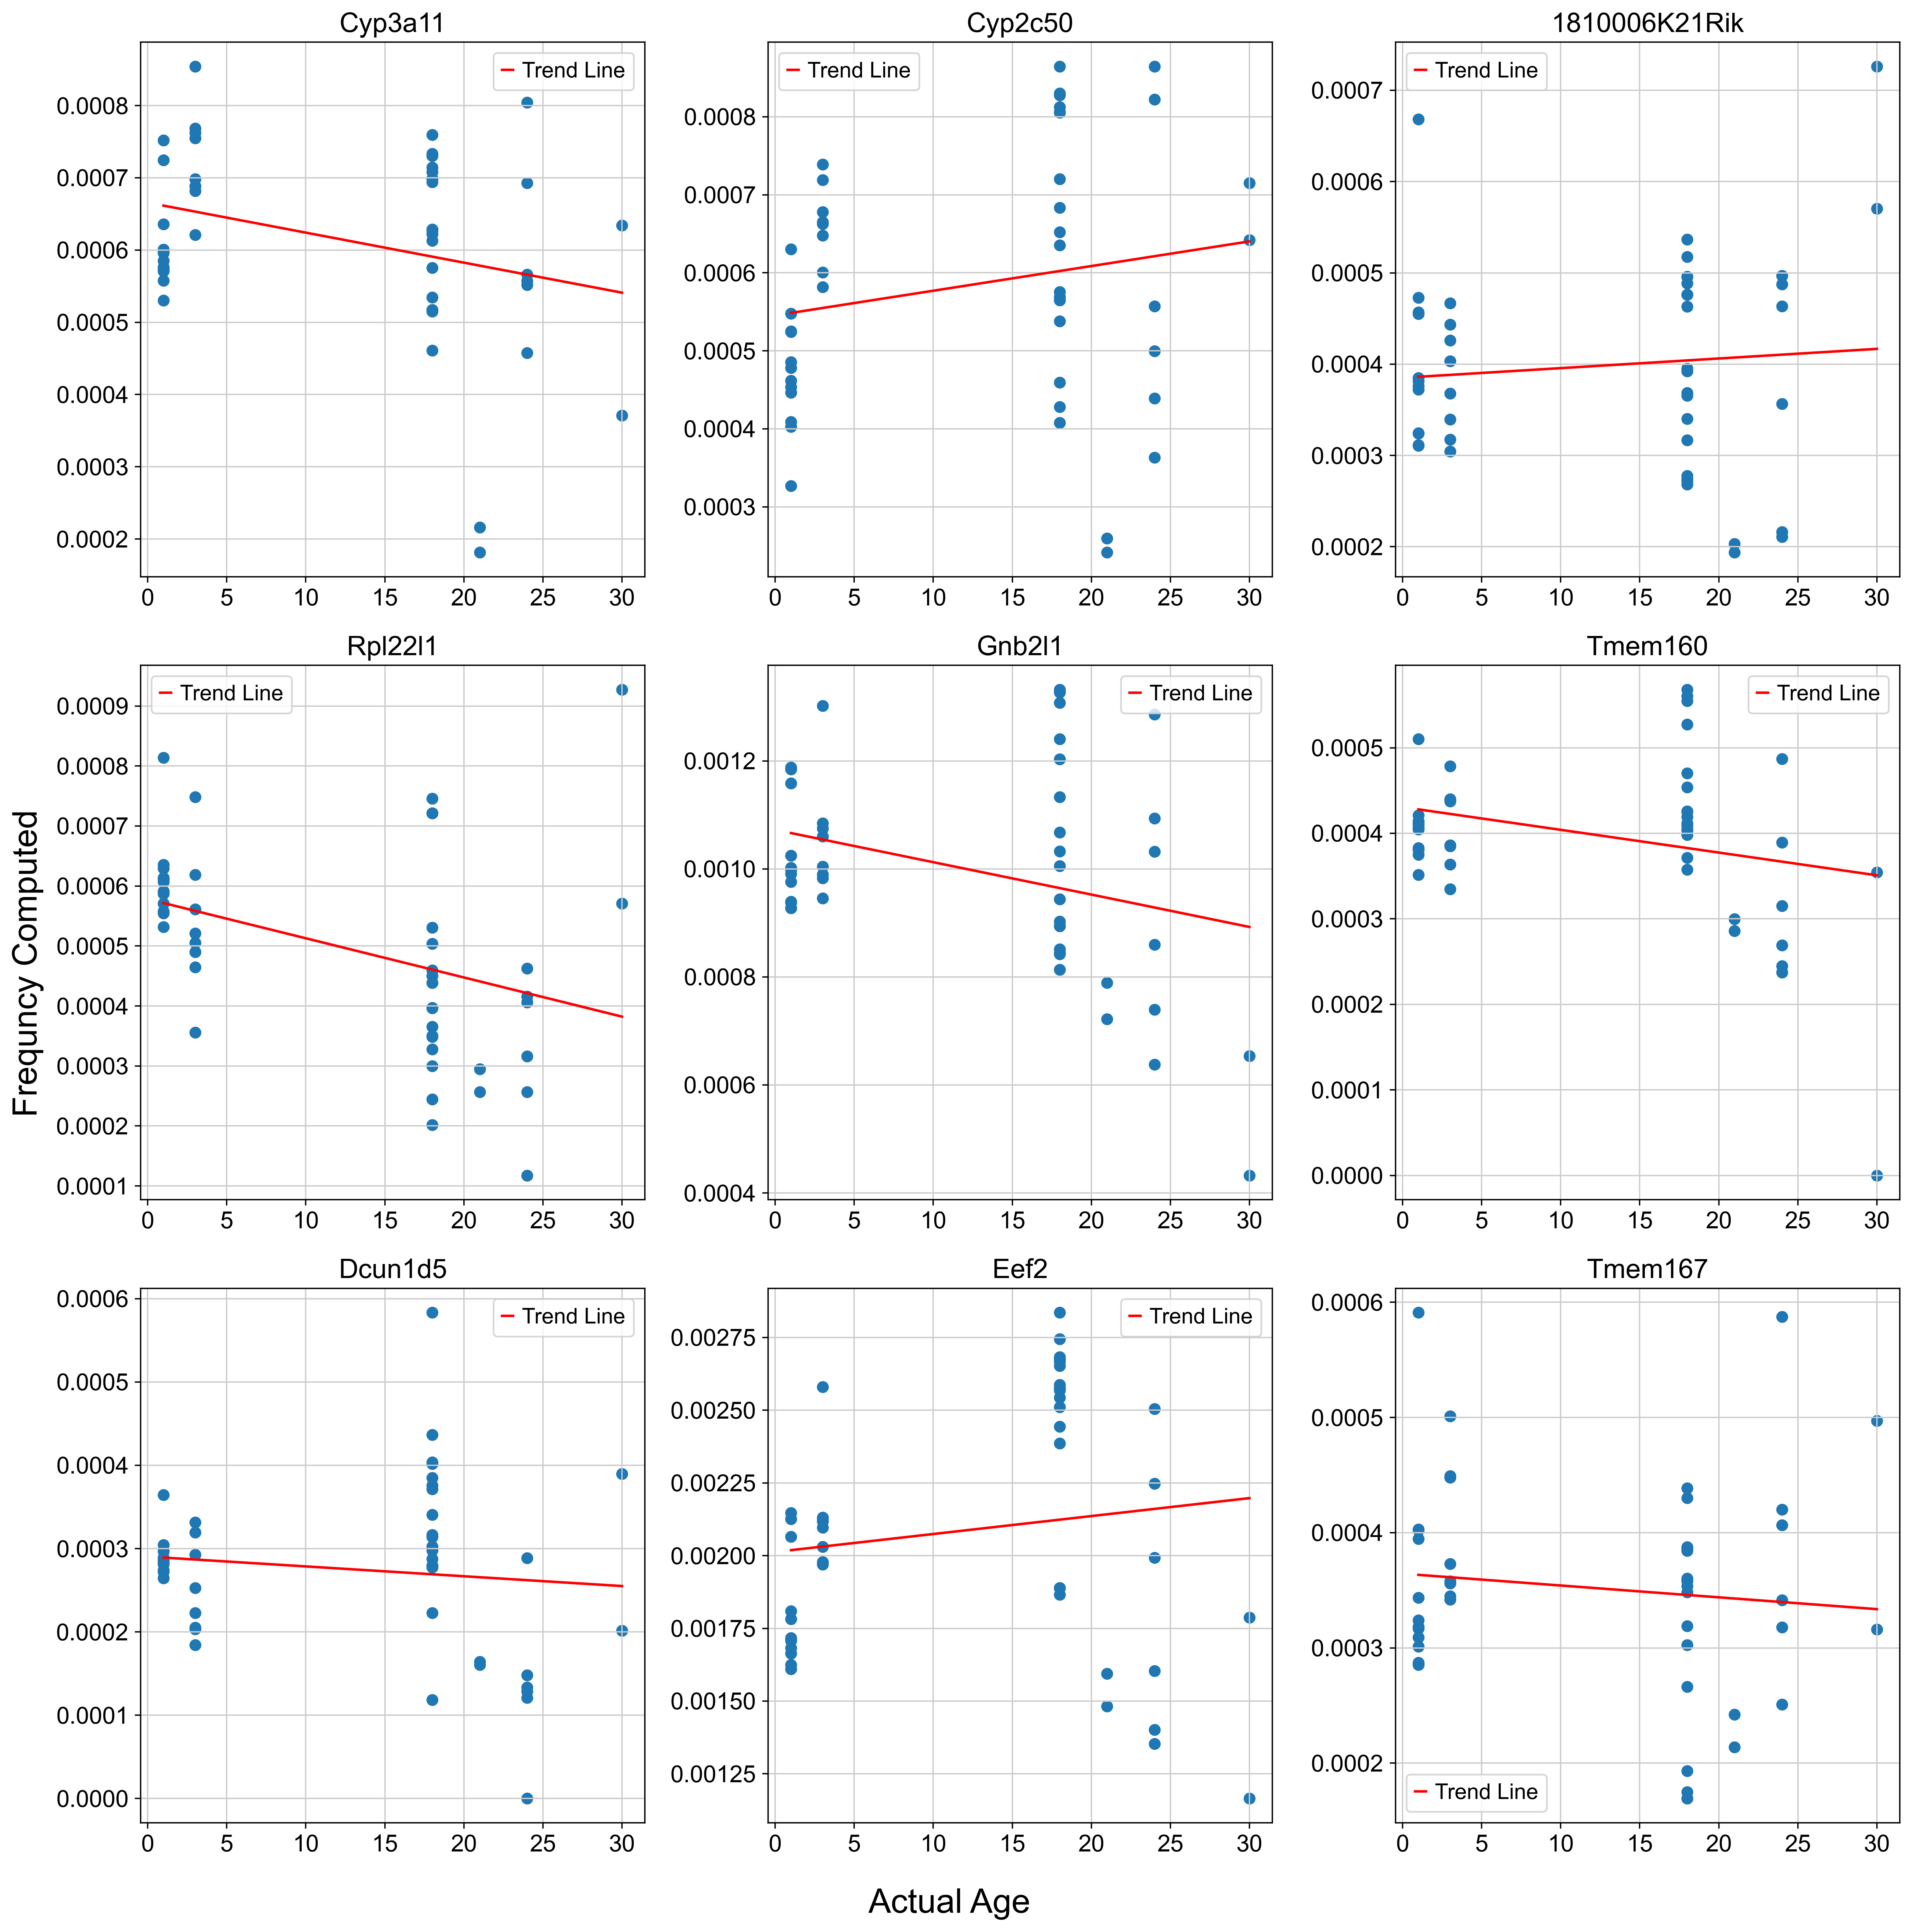

In [67]:
figure, axes = plt.subplots(3, 3, figsize = (16,16))
axes = axes.ravel()
genes = correlated_genes["hepatocyte"][:9]
test_exprs = []
test_ages = list(freq_matrices["hepatocyte"].columns)
test_freqs = freq_matrices["hepatocyte"].loc[genes,]
for i in tqdm(range(len(genes))):
    gene_exprs = test_freqs.loc[genes[i]]  # Get gene expression for the selected gene
    axes[i].scatter(test_ages, gene_exprs)
    z = np.polyfit(test_ages, gene_exprs, 1)  # Fit line
    p = np.poly1d(z)  # Create line equation
    axes[i].plot(sorted(test_ages), p(sorted(test_ages)), label="Trend Line", color='r')  # Sort ages for a smooth line
    axes[i].set_title(genes[i], fontsize=16)
    axes[i].legend()
figure.supylabel("Frequncy Computed", fontsize=20)
figure.supxlabel("Actual Age", fontsize=20)
figure.tight_layout()
plt.show()

100%|██████████| 9/9 [00:00<00:00, 600.47it/s]


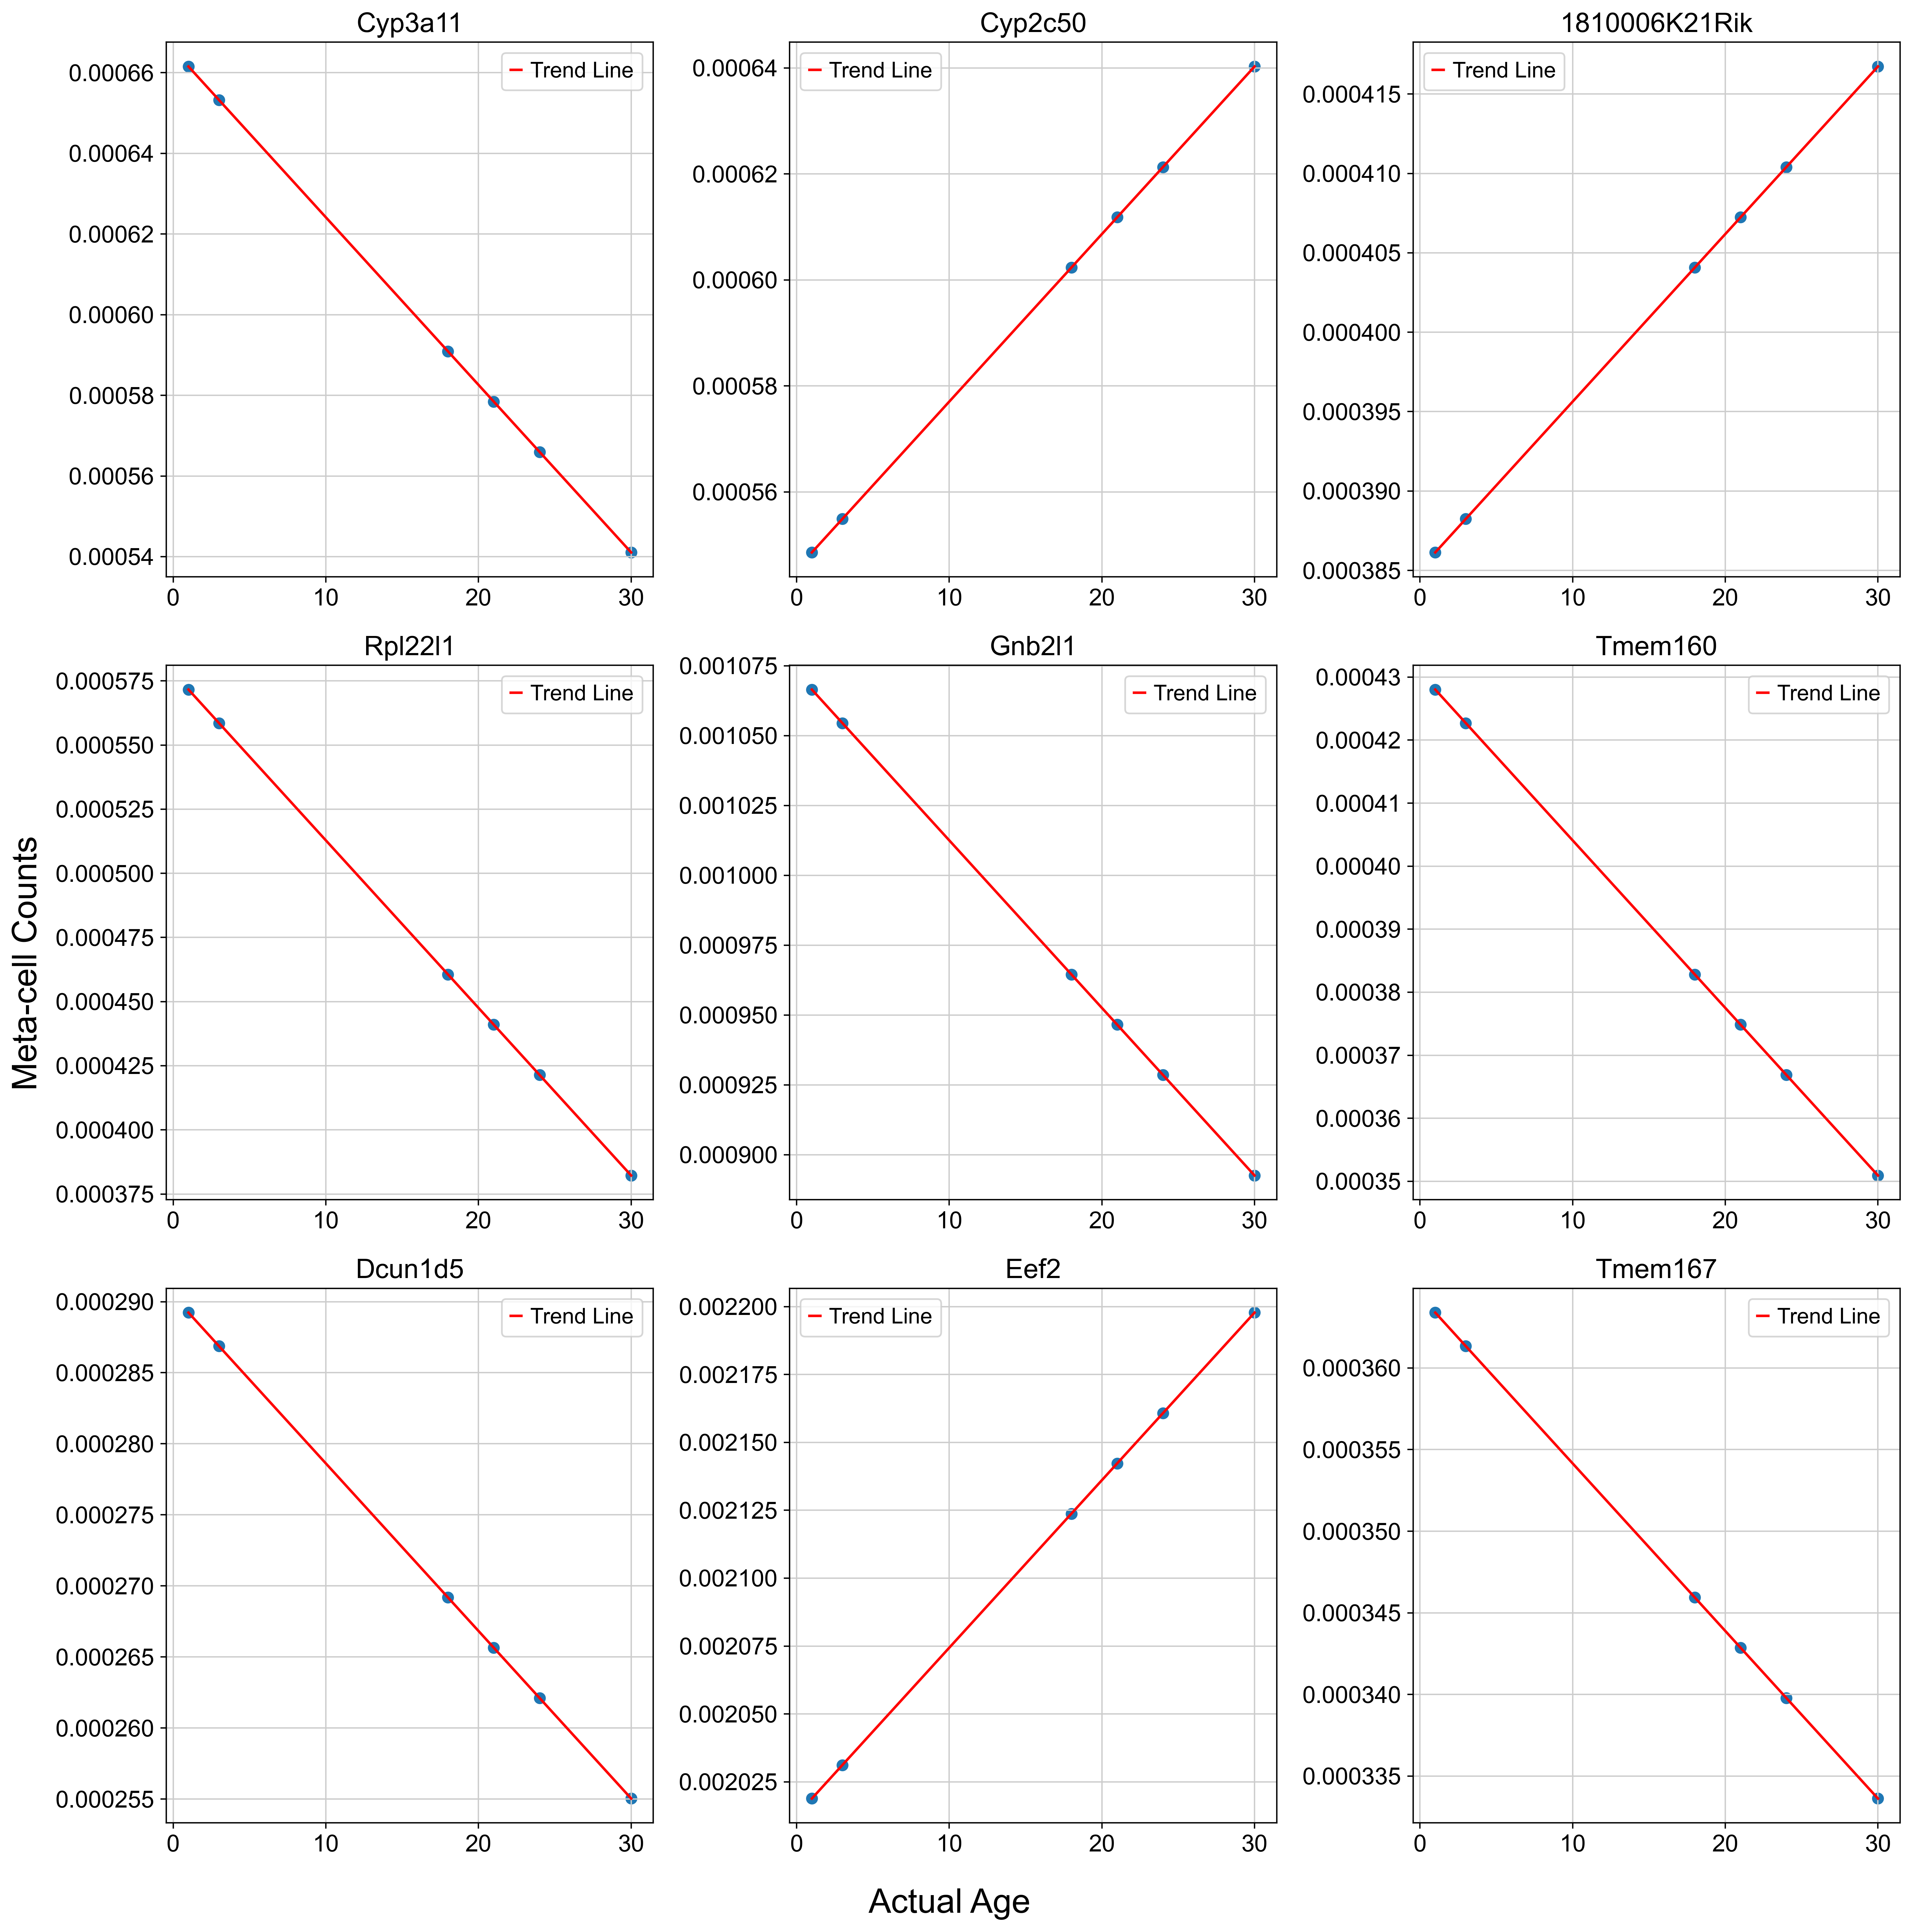

In [68]:
figure, axes = plt.subplots(3, 3, figsize = (16,16))
axes = axes.ravel()
genes = correlated_genes["hepatocyte"][:9]
test_exprs = []
test_ages = list(pred_freq_matrices["hepatocyte"].columns)
test_freqs = pred_freq_matrices["hepatocyte"].loc[genes,]
for i in tqdm(range(len(genes))):
    gene_exprs = test_freqs.loc[genes[i]]  # Get gene expression for the selected gene
    axes[i].scatter(test_ages, gene_exprs)
    z = np.polyfit(test_ages, gene_exprs, 1)  # Fit line
    p = np.poly1d(z)  # Create line equation
    axes[i].plot(sorted(test_ages), p(sorted(test_ages)), label="Trend Line", color='r')  # Sort ages for a smooth line
    axes[i].set_title(genes[i], fontsize=16)
    axes[i].legend()
figure.supylabel("Meta-cell Counts", fontsize=20)
figure.supxlabel("Actual Age", fontsize=20)
figure.tight_layout()
plt.show()

## Run Possion
r: Expected frequency from the linear model
k: counts of this specific gene
t: sum of the counts across all genes for that cell

In [69]:
from scipy.stats import poisson
import math
from numpy import inf

In [70]:
from collections import defaultdict
def get_cells_byAge(cell_group):
    cell_group_ages = age_df.T[cell_group.index]
    cell_group_age_dict = defaultdict(list)
    for cell in cell_group_ages:
        cell_group_age_dict[cell_group_ages[cell].values[0]].append(cell)
    return cell_group_age_dict

In [71]:
def get_singleCell_sums(cells):
    cell_sums = np.sum(cells, axis = 0)
    return(cell_sums)

In [72]:
from numpy import inf
def run_poisson(celltype, pred_freqs, raw_cells, age_classes):
    outcome = defaultdict(list)
    freq_probs = defaultdict(list)
    for age in pred_freqs:
#         print(f"-----processing {age}--------")
        cell_group_byAge = get_cells_byAge(raw_cells)
        cell_group = raw_cells.T[cell_group_byAge[age]]
        cell_sums = get_singleCell_sums(cell_group)
        for cell in cell_group:
            _lambda = pred_freqs * cell_sums[cell] # frequency of that gene expression * counts of all genes in that cell
            prob = poisson.pmf(np.array(cell_group[cell]).reshape(-1,1), _lambda)
            max_value = np.log(prob)
            max_value[max_value == -inf] = 0
#             temp = np.sum(max_value, axis = 0).reshape(1,-1)
            freq_probs[age].append(np.sum(max_value, axis = 0))
            age_poss = age_classes[np.argmax(np.sum(max_value, axis = 0))]
            outcome[age].append(age_poss)
    
    pred_results[celltype] = outcome
    likelihood[celltype] = freq_probs
    actual_ages = []
    for key in list(outcome.keys()):
        actual_ages.extend(len(outcome[key]) * [key])
    
    return actual_ages, [int(inner) for outer in list(outcome.values()) for inner in outer]

In [73]:


def plot_violin(ax, x, y, name):
    data = pd.DataFrame({
    'Ages': x,
    'Predicted': y})
    # Calculate MAE
    mae = mean_absolute_error(x, y)
    pearson_rsquared = pearsonr(x, y)[0]**2
    spearman_rsquared = spearmanr(x, y)[0]**2
    
    record_r_squared(name, pearson_rsquared)
    
#     save_csv(name, pearson_rsquared, spearman_rsquared)

    sns.violinplot(x='Ages', y='Predicted', data=data, palette='Set2', ax = ax)
    
    ax.set_ylim(bottom=0)
    ax.text(0.64, 0.98, f'MAE: {mae:.2f}, $pearson^2$: {pearson_rsquared:.2f}, $spearman^2: {spearman_rsquared:.2f}$', transform=ax.transAxes, horizontalalignment='right', verticalalignment='top', fontsize=14, bbox=dict(facecolor='white', alpha=0.5))
    
    ax.set_ylabel("Predicted Age", fontsize = 16)
    ax.set_xlabel("True Age", fontsize = 16)
    ax.set_title(name, fontsize = 16)

In [74]:
def plot_cell_count(ax, train_cellCount_dict, test_cellCount_dict):
    ages = sorted(list(train_cellCount_dict.keys()))
    print(ages)
    
    # Convert the dictionaries to lists of values for seaborn
    train_counts = list(train_cellCount_dict.values())
    test_counts = list(test_cellCount_dict.values())
    
    bar_width = 0.4
    # Set position of bars on X axis
    r1 = np.arange(len(ages))
    r2 = [x + bar_width for x in r1]
    
    # Use different colors for each x value
    unique_colors = sns.color_palette("Set2", len(ages))

    for i in range(len(ages)):
        ax.bar(r1[i], train_counts[i], color=unique_colors[i], width=bar_width, edgecolor='grey', label=f'Train (Age {ages[i]})')
        ax.bar(r2[i], test_counts[i], color=unique_colors[i], alpha=0.7, width=bar_width, edgecolor='grey', label=f'Test (Age {ages[i]})')
    
    ax.set_xlabel('Age', fontsize=16)
    ax.set_ylabel('Count', fontsize=16)
    ax.set_title('Num of Cells for Each Age (Train vs Test)', fontsize=16)
    ax.set_xticks([r + bar_width / 2 for r in range(len(ages))])
    ax.set_xticklabels(ages)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    # Add text labels above bars for train and test counts
    for i, value in enumerate(train_counts):
        ax.text(r1[i], value, f'{int(value)}', ha='center', va='bottom', fontsize=10, color='black')
    
    for i, value in enumerate(test_counts):
        ax.text(r2[i], value, f'{int(value)}', ha='center', va='bottom', fontsize=10, color='black')

In [75]:
def plot_pred_freq(x, y, name):
    data = pd.DataFrame({
    'Ages': x,
    'Predicted': y})

    sns.scatterplot(x='Ages', y='Predicted', data=data, palette='Set2', ax = ax)
    ax.set_ylim(bottom=0)    
    ax.set_ylabel("Frequencies", fontsize = 16)
    ax.set_xlabel("True Age", fontsize = 16)
    ax.set_title(name, fontsize = 16)

In [76]:
def record_r_squared(celltype, r_squared):
    file_path = "Liver_r_squared_summary.csv"
    # Create a new DataFrame with celltype as the index and r_squared value
    df = pd.DataFrame({'R_squared': [r_squared]}, index=[celltype])
    
    # Check if the file exists
    if not os.path.isfile(file_path):
        # If the file does not exist, write the new DataFrame to a CSV file
        df.to_csv(file_path, mode='w')
    else:
        # If the file exists, append the new data
        df.to_csv(file_path, mode='a', header=False)

In [77]:
# Initialize dictionaries for results
pred_results = {}
likelihood = {}

In [78]:
import warnings
warnings.filterwarnings('ignore')

Processing cell type: hepatocyte
[ 1  3 18 21 24 30]
{1: 0, 2: 0.05860467659366905, 4: 0.04829044679662063, 8: 0.03961684520794569, 16: 0.004406741143701851, 32: 0.028711506632962375, 64: 0.13314838236223897, 128: 0.23705775799781545, 256: 0.24319610557732316, 512: 0.21963262112772344, 1024: 0.2490694080146235, 2048: 0.264580375078976}
Model using 2048 numbers of genes
Counter({1: 994, 3: 666, 21: 180, 18: 159, 24: 43, 30: 18}) Counter({1: 245, 3: 162, 21: 49, 18: 35, 24: 20, 30: 5})
[1, 3, 18, 21, 24, 30]


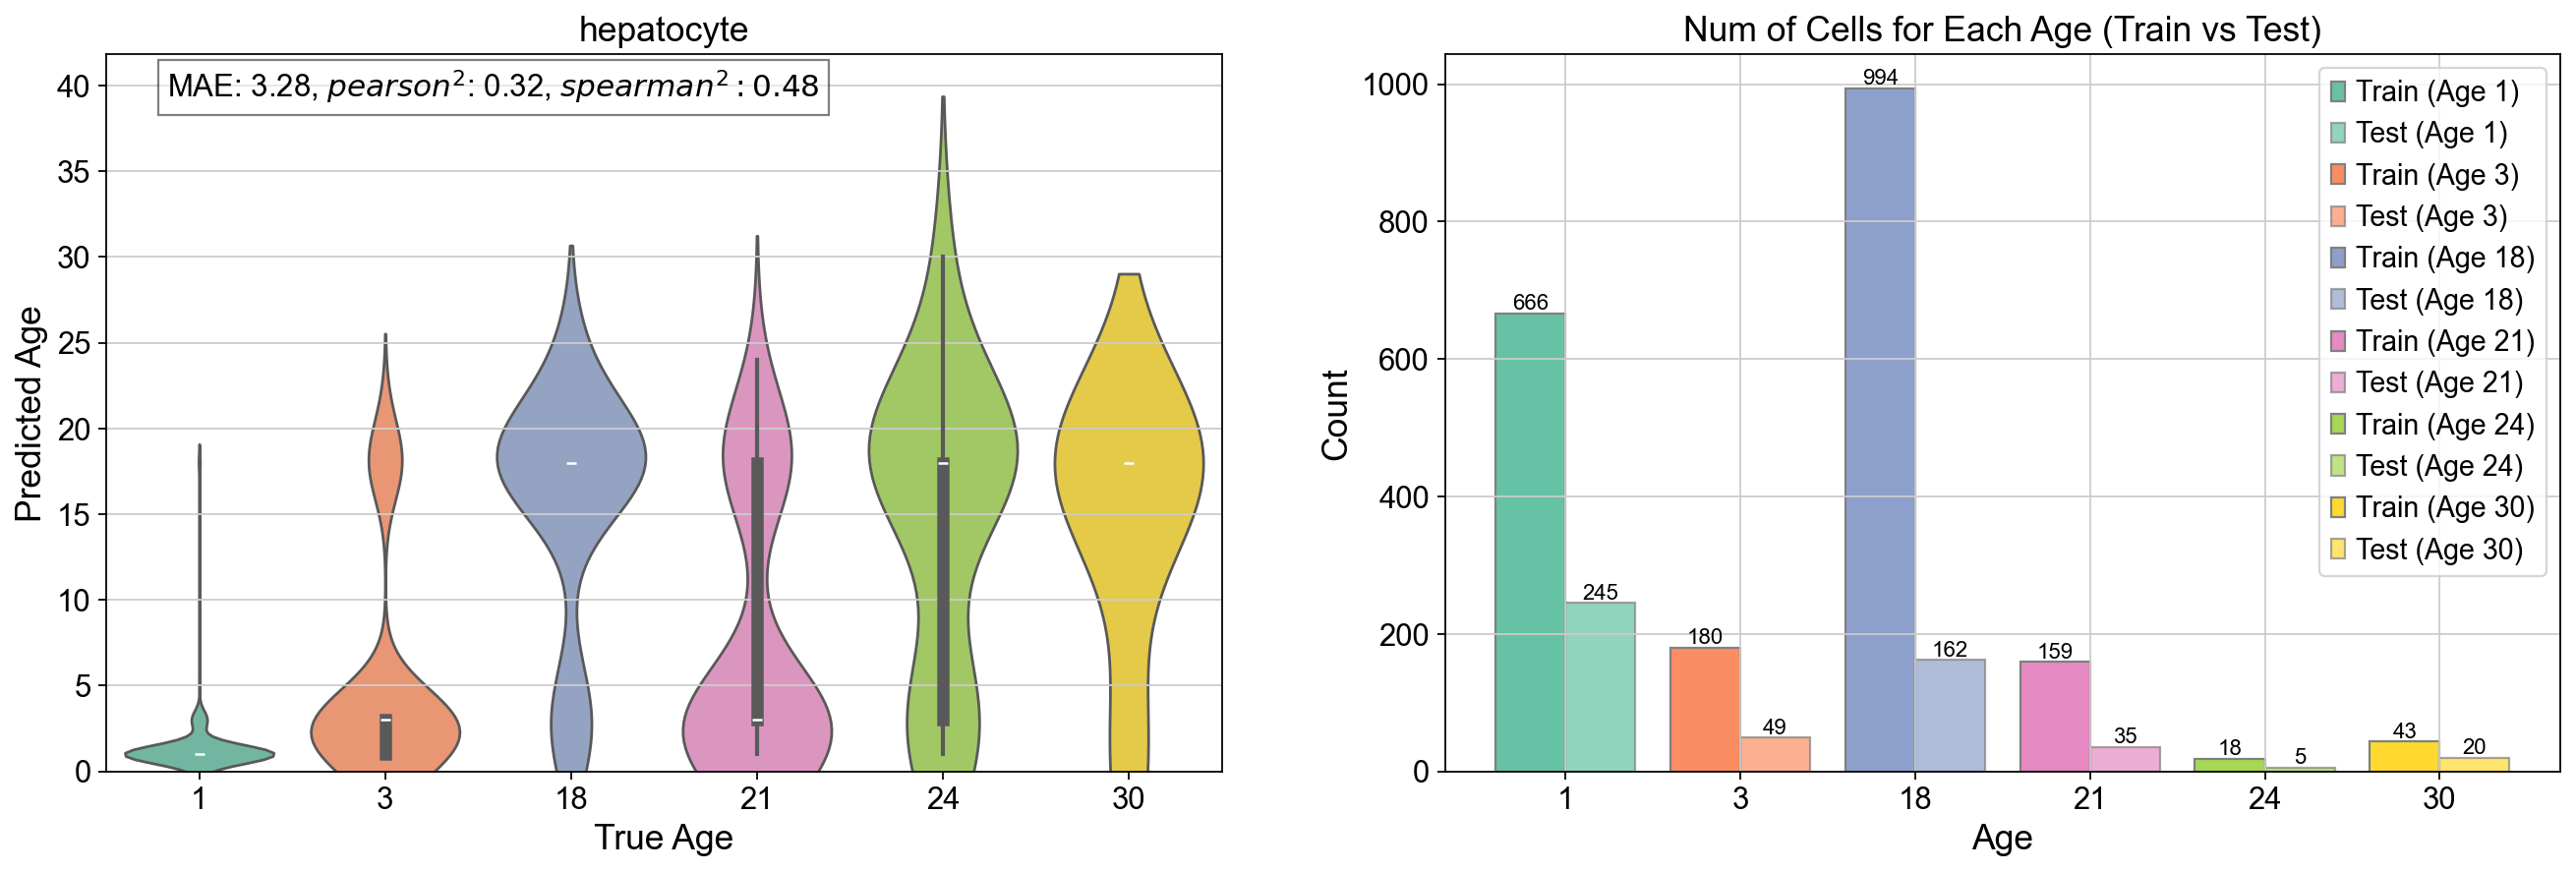

Processing cell type: Kupffer cell
[ 1 18 21 24 30]
{1: 0, 2: 0, 4: 0, 8: 0, 16: 0.7425829022237322, 32: 0.7862314846088134, 64: 0.7101496786451209, 128: 0.6938529218724014, 256: 0.7287587106603777, 512: 0.7383128005008814, 1024: 0.6750788227086901, 2048: 0.5186034869423148}
Model using 32 numbers of genes
Counter({30: 1314, 1: 402, 18: 159, 21: 14, 24: 12, 3: 8}) Counter({30: 336, 1: 92, 18: 36, 21: 7, 24: 6, 3: 1})
[1, 3, 18, 21, 24, 30]


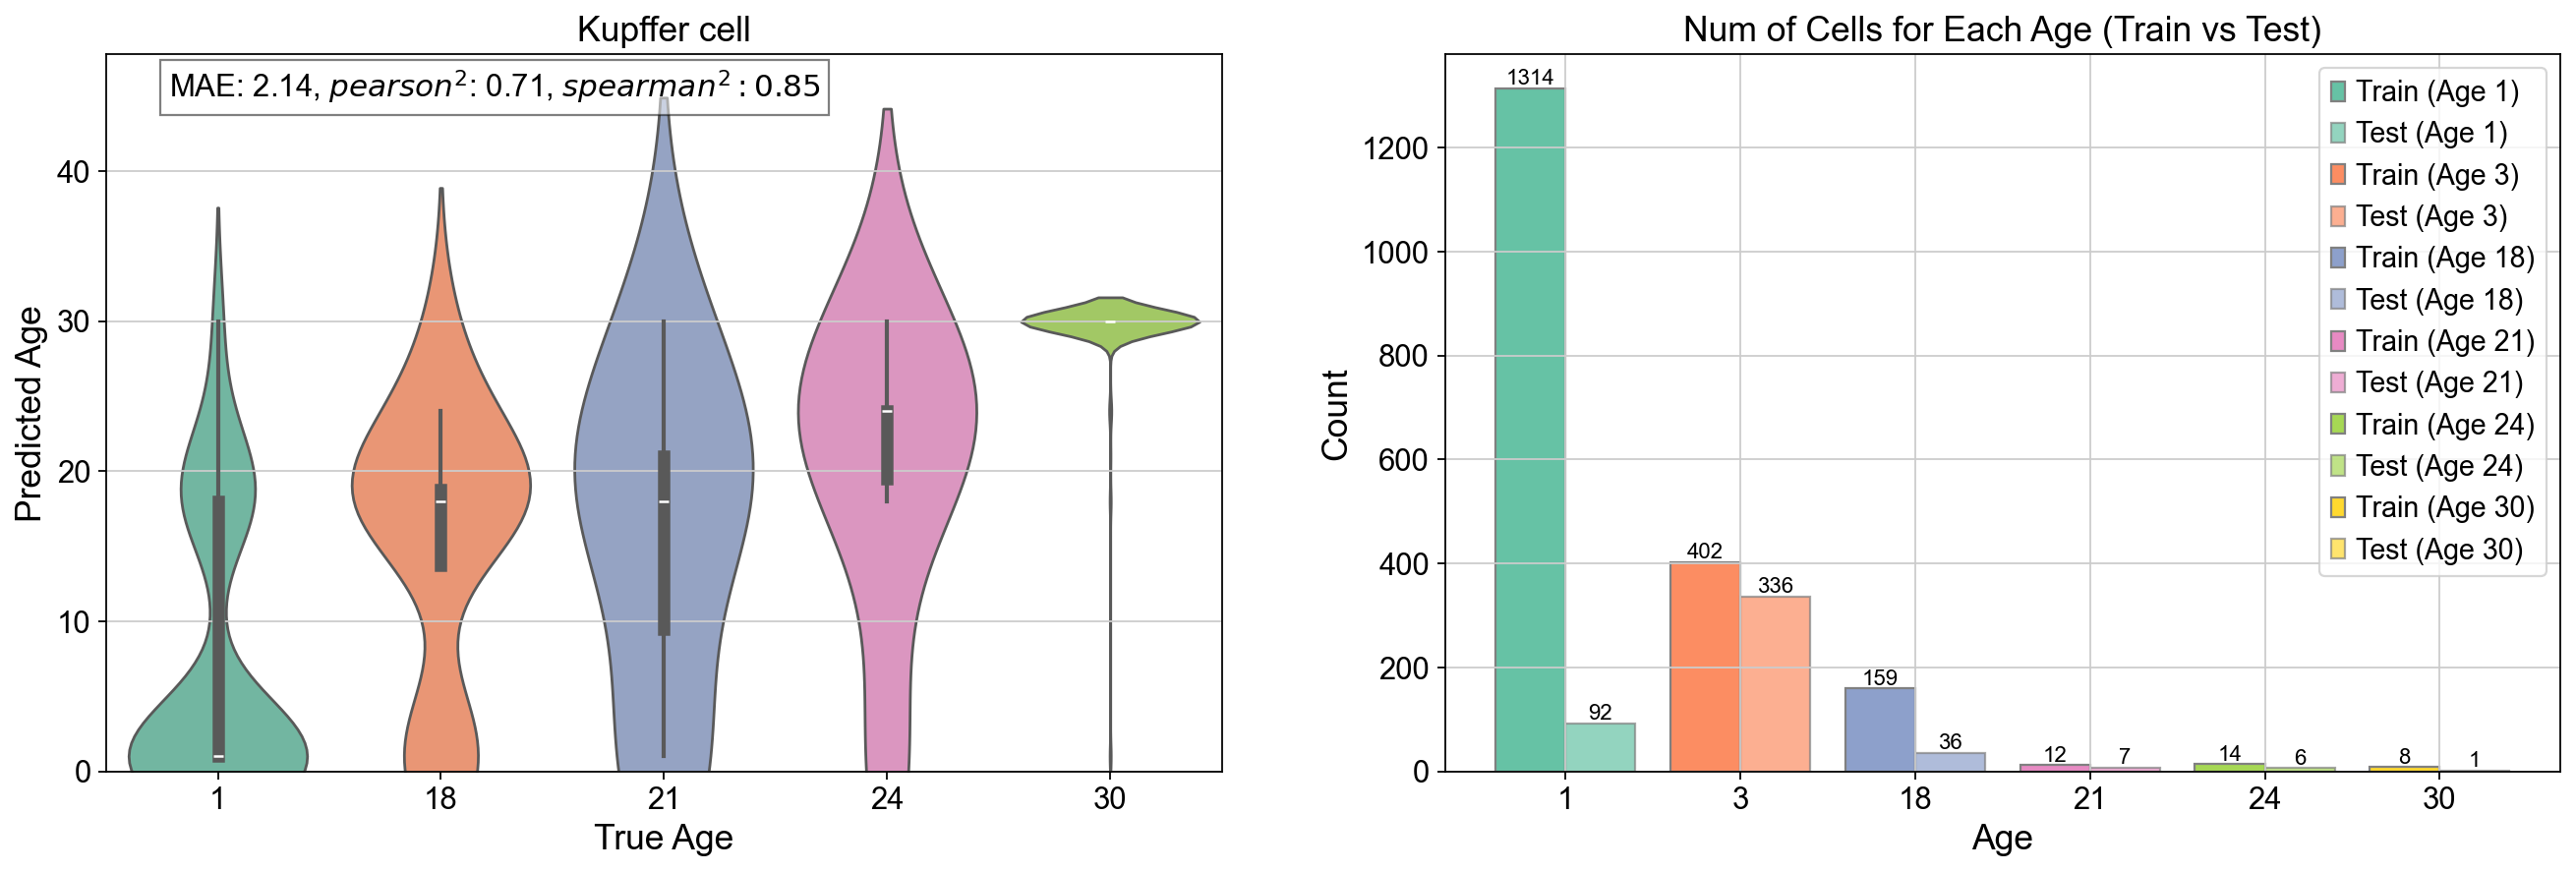

In [79]:
pred_results = {}
likelihood = {}



# Dictionary to store r_squared values for each cell type and gene count
r_squared_results = {}

# Iterate over each cell type in the predicted frequency matrices
for celltype in pred_freq_matrices:
    print(f"Processing cell type: {celltype}")
    
    raw_cells = pd.DataFrame(raw_count[celltype_dict[celltype]])
    ages = age_df.T[raw_cells.columns]
    
    # Split the cells into 80% training and 20% testing
    train_age, test_age = train_test_split(
        ages.T, test_size=0.2, random_state=42)
    
    train_cells = raw_cells[train_age.index].T
    test_cells = raw_cells[test_age.index].T
    
    # Select the correlated genes for the current cell type
    correlated_gene_list = correlated_genes[celltype]
    
    # Retrieve the training ages for the current cell type
    train_age_data = np.unique(train_age_groups[celltype])
    print(train_age_data)
    
    # Store cross-entropy results for different gene counts
    celltype_r_squared = {}
    
    i = 0
    while (2**i) <= len(correlated_gene_list) / 2:
        gene_count = 2**i
        i += 1
        selected_genes = correlated_gene_list[:gene_count]
        # Retrieve the predicted frequency matrix for the current cell type
        pred_freqs = pred_freq_matrices[celltype].loc[selected_genes]
        
        # Filter raw cells to include only the top 'num_genes' correlated genes
        filtered_train_cells = train_cells[selected_genes]
    
        # Run the poisson function
        true_ages, predicted_ages = run_poisson(celltype, pred_freqs, filtered_train_cells, train_age_data)
        
        # get the pearsonr
        pearson_rsquared = pearsonr(true_ages, predicted_ages)[0]**2
        celltype_r_squared[gene_count] = pearson_rsquared
    
    # Store cross-entropy results for the cell type
    r_squared_results[celltype] = {num_genes: (np.max(r_squareds) if not np.isnan(r_squareds).any() else 0) for num_genes, r_squareds in celltype_r_squared.items()}
    print(r_squared_results[celltype])
    optimal_gene_counts = max(r_squared_results[celltype], key=r_squared_results[celltype].get)
    print(f"Model using {optimal_gene_counts} numbers of genes")
    
    selected_genes = correlated_gene_list[:optimal_gene_counts]
    pred_freqs = pred_freq_matrices[celltype].loc[selected_genes]
    filtered_test_cells = test_cells[selected_genes]
    true_ages, predicted_ages = run_poisson(celltype, pred_freqs, filtered_test_cells, train_age_data)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), dpi=80)
    
    plot_violin(ax1, true_ages, predicted_ages, celltype)
    print(Counter(train_age["age"]), Counter(test_age["age"]))
    plot_cell_count(ax2, Counter(train_age["age"]), Counter(test_age["age"]))
    plt.show()